Base.py


In [ ]:
from dataclasses import dataclass
from typing import Literal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

# Each node in the decision tree
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature      # which column (feature) is used for split
        self.threshold = threshold  # the cut-off value for split
        self.left = left            # left child node
        self.right = right          # right child node
        self.value = value          # final prediction (for leaf nodes)

    def is_leaf_node(self):
        return self.value is not None   # leaf nodes have a value instead of children

@dataclass
class DecisionTree:
    criterion: Literal["information_gain", "gini_index"]
    max_depth: int

    def __init__(self, criterion="information_gain", max_depth=5):
        self.criterion = criterion
        self.max_depth = max_depth
        self.root = None
        self.features_ = None

    # Train the tree
    def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        self.features_ = X.columns.tolist()   # keep track of column names
        self.root = self._grow_tree(X, y)     # recursively build the tree

    # Recursively grow the tree
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(y.unique())

        # Stop if: tree is deep enough OR only one label left OR too few samples
        if (depth >= self.max_depth or n_labels == 1 or n_samples < 2):
            leaf_value = self._leaf_value(y)   # return the final prediction
            return Node(value=leaf_value)

        # Find the best feature and threshold to split
        best_feature_idx, best_thresh = opt_split_attribute(X, y, self.criterion)

        if best_feature_idx is None:  # if no split possible
            leaf_value = self._leaf_value(y)
            return Node(value=leaf_value)

        best_feature_name = X.columns[best_feature_idx]

        # Split data into left/right groups
        if pd.api.types.is_numeric_dtype(X[best_feature_name]):
            left_mask = X[best_feature_name] <= best_thresh
            right_mask = X[best_feature_name] > best_thresh
        else:
            left_mask = X[best_feature_name] == best_thresh
            right_mask = X[best_feature_name] != best_thresh

        left_X, left_y = X.loc[left_mask], y.loc[left_mask]
        right_X, right_y = X.loc[right_mask], y.loc[right_mask]

        # Build left and right subtrees
        left = self._grow_tree(left_X, left_y, depth + 1)
        right = self._grow_tree(right_X, right_y, depth + 1)
        return Node(best_feature_idx, best_thresh, left, right)

    # How to calculate value at a leaf
    def _leaf_value(self, y):
        if check_if_real(y):   # regression -> take mean
            return y.mean()
        else:                  # classification -> take majority class
            return y.mode().iloc[0]

    # Make predictions for new data
    def predict(self, X: pd.DataFrame) -> pd.Series:
        return X.apply(self._traverse_tree, axis=1, args=(self.root,))

    # Traverse down the tree to predict a single row
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        feature_name = self.features_[node.feature]

        # numeric split
        if pd.api.types.is_numeric_dtype(x[feature_name]):
            if x[feature_name] <= node.threshold:
                return self._traverse_tree(x, node.left)
            else:
                return self._traverse_tree(x, node.right)
        # categorical split
        else:
            if x[feature_name] == node.threshold:
                return self._traverse_tree(x, node.left)
            else:
                return self._traverse_tree(x, node.right)

    # Assign positions for plotting the tree
    def _assign_positions(self, node, depth=0):
        if node.is_leaf_node():
            return {node: (0, -depth)}, 1

        left_pos, left_width = self._assign_positions(node.left, depth + 1)
        right_pos, right_width = self._assign_positions(node.right, depth + 1)

        for n, (x, y) in right_pos.items():
            right_pos[n] = (x + left_width + 1, y)

        positions = {**left_pos, **right_pos}

        # x-position = average of left and right children
        left_root_x = left_pos[node.left][0]
        right_root_x = right_pos[node.right][0]
        node_x = (left_root_x + right_root_x) / 2
        positions[node] = (node_x, -depth)

        total_width = left_width + right_width + 1
        return positions, total_width

    # Draw the tree
    def plot(self, title="", metrics_text="") -> None:
        if self.root is None:
            print("Tree has not been fitted yet.")
            return

        positions, _ = self._assign_positions(self.root)

        # Recenter positions so root is at 0
        if positions:
            root_x = positions[self.root][0]
            for node in positions:
                x, y = positions[node]
                positions[node] = (x - root_x, y)

        fig, ax = plt.subplots(figsize=(15, 10))
        ax.axis('off')

        # Draw each node and its connections
        for node, (x, y) in positions.items():
            bbox_props = dict(boxstyle="round,pad=0.4", fc="lightblue", ec="b", lw=1)

            if node.is_leaf_node():
                node_text = f"Value = {node.value:.2f}" if isinstance(node.value, float) else f"Class = {node.value}"
            else:
                feature_name = self.features_[node.feature]
                threshold_str = f"{node.threshold:.2f}" if isinstance(node.threshold, (int, float)) else f"{node.threshold}"
                node_text = f"{feature_name}\n<= {threshold_str}"

            ax.text(x, y, node_text, ha="center", va="center", size=8, bbox=bbox_props)

            if not node.is_leaf_node():
                x_left, y_left = positions[node.left]
                x_right, y_right = positions[node.right]
                ax.plot([x, x_left], [y, y_left], "k-", lw=1)
                ax.plot([x, x_right], [y, y_right], "k-", lw=1)

        plt.title(title, size=16)
        fig.text(0.05, 0.05, metrics_text, ha="left", va="bottom", fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.5", fc="lightgray", ec="black", lw=1))
        plt.tight_layout()
        plt.show()


This code builds a simple decision tree from scratch.
Node defines each point in the tree — it can either split on a feature or store a final prediction (leaf).

DecisionTree handles training, predicting, and plotting.
fit grows the tree recursively by finding the best feature/threshold to split on.

leaf value decides what value a leaf node should predict (average for regression, majority class for classification).
predict runs new data down the tree until it hits a leaf.

_assign_positions and plot are just for visualization so you can see the tree structure.

Basically, it trains a decision tree on your data, makes predictions, and can also draw the tree so you can understand the splits.

Utils.py

In [ ]:
import pandas as pd
import numpy as np

def check_if_real(y: pd.Series) -> bool:
    # Check if target values are real (float) → regression
    # Otherwise → classification
    return y.dtype == 'float'

def entropy(y: pd.Series) -> float:
    # Calculate entropy (used for classification impurity)
    if y.size == 0:
        return 0
    counts = y.value_counts()
    probabilities = counts / y.size
    probabilities = probabilities[probabilities > 0]
    return -np.sum(probabilities * np.log2(probabilities))

def gini_index(y: pd.Series) -> float:
    # Calculate Gini index (alternative impurity measure)
    if y.size == 0:
        return 0
    counts = y.value_counts()
    probabilities = counts / y.size
    return 1 - np.sum(probabilities**2)

def information_gain(y: pd.Series, left_y: pd.Series, right_y: pd.Series, criterion: str) -> float:
    # Compute information gain from a split
    if check_if_real(y):
        # Regression case → use Mean Squared Error (MSE)
        parent_mse = np.mean((y - y.mean())**2)
        left_mse = np.mean((left_y - left_y.mean())**2) if not left_y.empty else 0
        right_mse = np.mean((right_y - right_y.mean())**2) if not right_y.empty else 0

        n = len(y)
        n_left = len(left_y)
        n_right = len(right_y)

        weighted_mse = (n_left / n) * left_mse + (n_right / n) * right_mse
        return parent_mse - weighted_mse
    else:
        # Classification case → use entropy or gini
        if criterion == 'information_gain':
            impurity_func = entropy
        else:
            impurity_func = gini_index

        parent_impurity = impurity_func(y)
        left_impurity = impurity_func(left_y)
        right_impurity = impurity_func(right_y)

        n = len(y)
        n_left = len(left_y)
        n_right = len(right_y)

        weighted_impurity = (n_left / n) * left_impurity + (n_right / n) * right_impurity
        return parent_impurity - weighted_impurity

def opt_split_attribute(X: pd.DataFrame, y: pd.Series, criterion):
    # Find the best feature + threshold to split on
    best_gain = -1
    best_feature_idx = None
    best_value = None

    # Loop through all features
    for feature_idx in range(X.shape[1]):
        feature_name = X.columns[feature_idx]
        values = X[feature_name].unique()

        # Try splitting at each unique value
        for value in values:
            if pd.api.types.is_numeric_dtype(X[feature_name]):
                # Numeric feature → threshold split
                left_mask = X[feature_name] <= value
                right_mask = X[feature_name] > value
            else:
                # Categorical feature → equality split
                left_mask = X[feature_name] == value
                right_mask = X[feature_name] != value

            left_y, right_y = y[left_mask], y[right_mask]

            # Skip invalid splits
            if len(left_y) == 0 or len(right_y) == 0:
                continue

            # Calculate info gain for this split
            gain = information_gain(y, left_y, right_y, criterion)
            if gain > best_gain:
                best_gain = gain
                best_feature_idx = feature_idx
                best_value = value

    return best_feature_idx, best_value


This code defines the core math behind how a decision tree decides where to split:

check_if_real → figures out if it’s a regression (numeric target) or classification problem.

entropy and gini_index → measure impurity (how mixed the classes are).

information_gain → calculates how much better a split makes things (using MSE for regression, entropy/gini for classification).

opt_split_attribute → tries all features and values, finds the best split that gives the highest information gain.

In short: this is the engine that picks the “best question” at each node of the tree.

metrics

In [ ]:
from typing import Union
import numpy as np
import pandas as pd



def accuracy(y_hat: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the accuracy
    """
    assert y_hat.size == y.size
    return (y_hat == y).sum() / len(y)


def precision(y_hat: pd.Series, y: pd.Series, cls: Union[int, str]) -> float:
    """
    Function to calculate the precision
    """
    assert y_hat.size == y.size
    true_positives = ((y_hat == cls) & (y == cls)).sum()
    predicted_positives = (y_hat == cls).sum()
    return true_positives / predicted_positives if predicted_positives > 0 else 0


def recall(y_hat: pd.Series, y: pd.Series, cls: Union[int, str]) -> float:
    """
    Function to calculate the recall
    """
    assert y_hat.size == y.size
    true_positives = ((y_hat == cls) & (y == cls)).sum()
    actual_positives = (y == cls).sum()
    return true_positives / actual_positives if actual_positives > 0 else 0


def rmse(y_hat: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the root-mean-squared-error(rmse)
    """
    assert y_hat.size == y.size
    return np.sqrt(((y_hat - y) ** 2).mean())


def mae(y_hat: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the mean-absolute-error(mae)
    """
    assert y_hat.size == y.size
    return (y_hat - y).abs().mean()

autoefficiency.py

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor


np.random.seed(42)

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
data = pd.read_csv(url, delim_whitespace=True, header=None,
                 names=["mpg", "cylinders", "displacement", "horsepower", "weight",
                        "acceleration", "model year", "origin", "car name"])

data = data.drop("car name", axis=1)
data['horsepower'] = pd.to_numeric(data['horsepower'], errors='coerce')
data = data.dropna()

X = data.drop("mpg", axis=1)
y = data["mpg"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# My Decision Tree
my_tree = DecisionTree(max_depth=5)
my_tree.fit(X_train, y_train)
my_y_hat = my_tree.predict(X_test)
print("--- My Decision Tree Performance ---")
print("RMSE:", rmse(my_y_hat, y_test))
print("MAE:", mae(my_y_hat, y_test))

# Scikit-learn Decision Tree
sklearn_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
sklearn_tree.fit(X_train, y_train)
sklearn_y_hat = pd.Series(sklearn_tree.predict(X_test))
print("\n--- Scikit-learn Decision Tree Performance ---")
print("RMSE:", rmse(sklearn_y_hat, y_test))
print("MAE:", mae(sklearn_y_hat, y_test))

/tmp/ipython-input-539597211.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(url, delim_whitespace=True, header=None,


--- My Decision Tree Performance ---
RMSE: 3.305969605525706
MAE: 2.2895325811567435

--- Scikit-learn Decision Tree Performance ---
RMSE: 10.13118990379059
MAE: 8.517569987475701


Loaded the Auto MPG dataset from UCI.

Preprocessed the data: dropped irrelevant columns, converted horsepower to numeric, and removed missing rows.

Split the dataset into training and testing sets.

Trained our own Decision Tree (max depth = 5) on the training set.

Evaluated our tree on the test set using RMSE and MAE.

Trained a scikit-learn DecisionTreeRegressor with the same depth for comparison.

Compared performance: printed RMSE and MAE for both implementations.

Classification

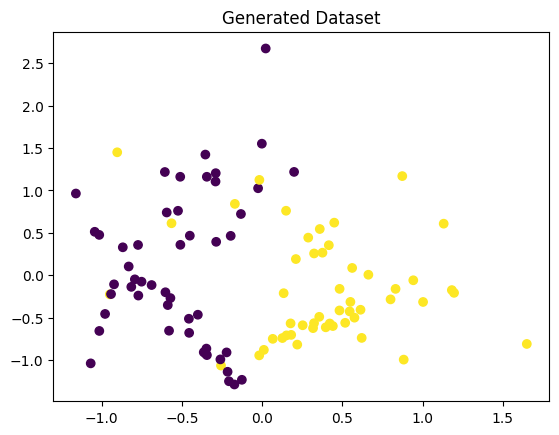

--- Q2 a) Results ---
Accuracy: 0.8333333333333334
Class 1 Precision: 0.8571428571428571
Class 1 Recall: 0.8
Class 0 Precision: 0.8125
Class 0 Recall: 0.8666666666666667

--- Q2 b) 5-Fold Cross-Validation ---
Depth: 1, Average Accuracy: 0.9
Depth: 2, Average Accuracy: 0.9200000000000002
Depth: 3, Average Accuracy: 0.9000000000000001
Depth: 4, Average Accuracy: 0.9000000000000001
Depth: 5, Average Accuracy: 0.89
Depth: 6, Average Accuracy: 0.8799999999999999
Depth: 7, Average Accuracy: 0.8699999999999999
Depth: 8, Average Accuracy: 0.8799999999999999
Depth: 9, Average Accuracy: 0.8699999999999999
Depth: 10, Average Accuracy: 0.8699999999999999

Optimal Depth: 2 with accuracy: 0.9200000000000002


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold

np.random.seed(42)

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=2, class_sep=0.5)

X = pd.DataFrame(X, columns=['feature1', 'feature2'])
y = pd.Series(y)

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y)
plt.title("Generated Dataset")
plt.show()

# Q2 a)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree = DecisionTree(criterion='information_gain', max_depth=5)
tree.fit(X_train, y_train)
y_hat = tree.predict(X_test)

print("--- Q2 a) Results ---")
print("Accuracy:", accuracy(y_hat, y_test))
for cls in y.unique():
    print(f"Class {cls} Precision:", precision(y_hat, y_test, cls))
    print(f"Class {cls} Recall:", recall(y_hat, y_test, cls))

# Q2 b)
print("\n--- Q2 b) 5-Fold Cross-Validation ---")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
depths = range(1, 11)
best_depth = -1
best_accuracy = -1

for depth in depths:
    accuracies = []
    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        tree = DecisionTree(max_depth=depth)
        tree.fit(X_train_fold, y_train_fold)
        y_hat_fold = tree.predict(X_val_fold)
        accuracies.append(accuracy(y_hat_fold, y_val_fold))

    avg_accuracy = np.mean(accuracies)
    print(f"Depth: {depth}, Average Accuracy: {avg_accuracy}")
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_depth = depth

print(f"\nOptimal Depth: {best_depth} with accuracy: {best_accuracy}")

Generated a synthetic classification dataset with 2 informative features using make_classification.

Visualized the dataset using a scatter plot to see the class separation.

Q2(a): Train/Test Split

Split the data into training (70%) and testing (30%).
Trained a custom DecisionTree (criterion = information gain, depth = 5).

Predicted on the test set and evaluated performance using Accuracy, Precision, and Recall for each class.

Q2(b): Cross-Validation for Hyperparameter Tuning
Performed 5-fold cross-validation across tree depths from 1 to 10.
Recorded average accuracy for each depth.
Found the optimal depth = 2, which gave the best accuracy (~0.92).

experiments.py

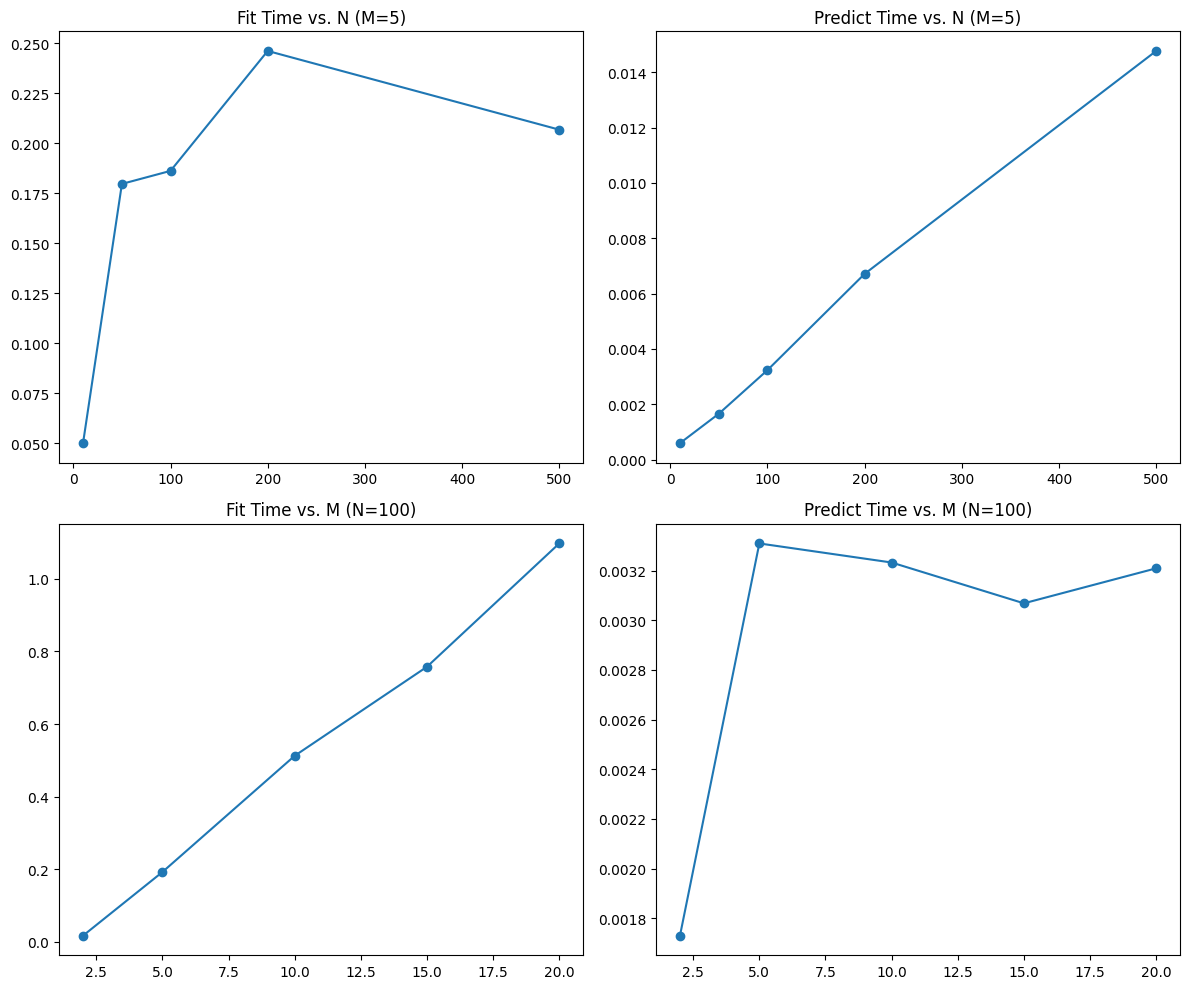

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# make random dataset
def generate_data(N, M, output_type='discrete'):
    X = pd.DataFrame(np.random.randint(0, 2, size=(N, M)))
    if output_type == 'discrete':
        y = pd.Series(np.random.randint(0, 2, size=N))
    else:
        y = pd.Series(np.random.rand(N))
    return X, y

# vary N (rows)
N_values = [10, 50, 100, 200, 500]
M = 5
fit_times_N, predict_times_N = [], []

for N in N_values:
    X, y = generate_data(N, M)
    tree = DecisionTree(max_depth=5)

    start = time.time(); tree.fit(X, y)
    fit_times_N.append(time.time() - start)

    start = time.time(); tree.predict(X)
    predict_times_N.append(time.time() - start)

# vary M (cols)
M_values = [2, 5, 10, 15, 20]
N = 100
fit_times_M, predict_times_M = [], []

for M in M_values:
    X, y = generate_data(N, M)
    tree = DecisionTree(max_depth=5)

    start = time.time(); tree.fit(X, y)
    fit_times_M.append(time.time() - start)

    start = time.time(); tree.predict(X)
    predict_times_M.append(time.time() - start)

# plots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(N_values, fit_times_N, marker='o')
axs[0, 0].set_title('Fit Time vs. N (M=5)')

axs[0, 1].plot(N_values, predict_times_N, marker='o')
axs[0, 1].set_title('Predict Time vs. N (M=5)')

axs[1, 0].plot(M_values, fit_times_M, marker='o')
axs[1, 0].set_title('Fit Time vs. M (N=100)')

axs[1, 1].plot(M_values, predict_times_M, marker='o')
axs[1, 1].set_title('Predict Time vs. M (N=100)')

plt.tight_layout()
plt.show()


What we have done:

Generated random datasets using a helper function generate_data with varying numbers of rows (N) and columns (M). The target y was generated either as discrete (classification) or continuous (regression).

Measured training (fit) and prediction times for a custom DecisionTree with maximum depth 5.

First, varied dataset size (N) while keeping features (M=5) fixed.
Then, varied number of features (M) while keeping dataset size (N=100) fixed.

Collected timing results for both fitting and prediction.
Visualized results in four plots:

Fit time vs. N
Predict time vs. N
Fit time vs. M
Predict time vs. M

What we have done

Defined evaluation metrics for both classification and regression tasks.

accuracy: proportion of correct predictions.

precision: proportion of predicted positives that are correct (per class).

recall: proportion of actual positives correctly identified (per class).

rmse: root-mean-square error, a common regression loss.
mae: mean absolute error, another regression loss.

Ensured input validation by asserting that predicted (y_hat) and true labels (y) have the same size.

Handled edge cases (e.g., no predicted positives for precision, no actual positives for recall) by returning 0 instead of raising errors.

Used pandas operations for concise and vectorized calculations.

usage.py

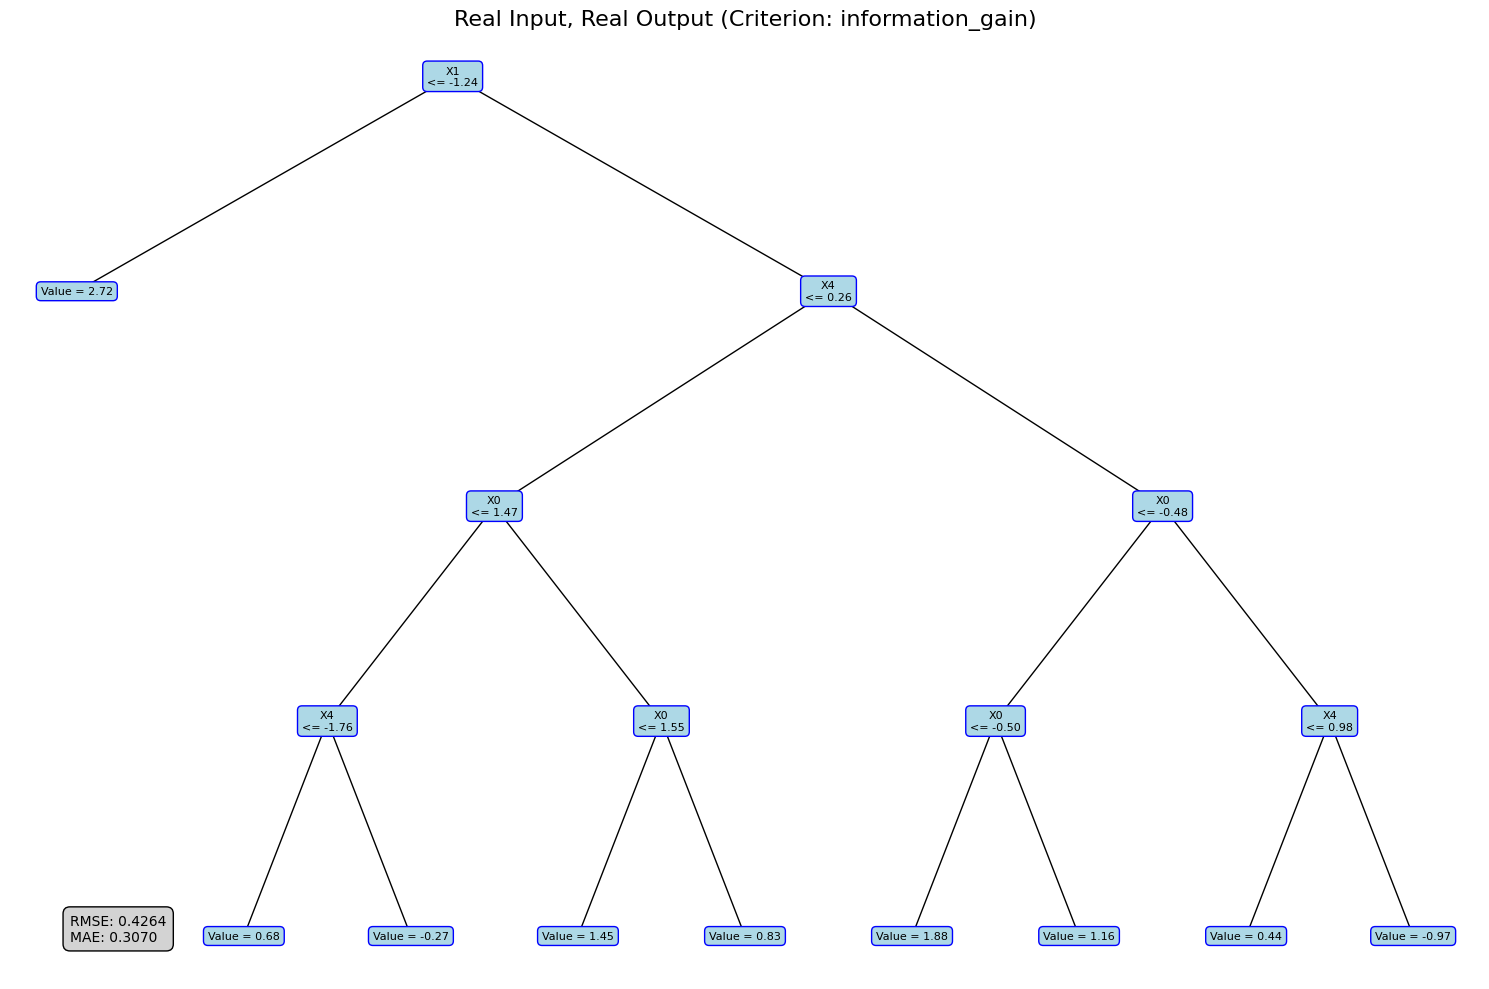


--- Real Input, Real Output (Criterion: information_gain) ---
RMSE:  0.426442114449805
MAE:  0.30700279356730054


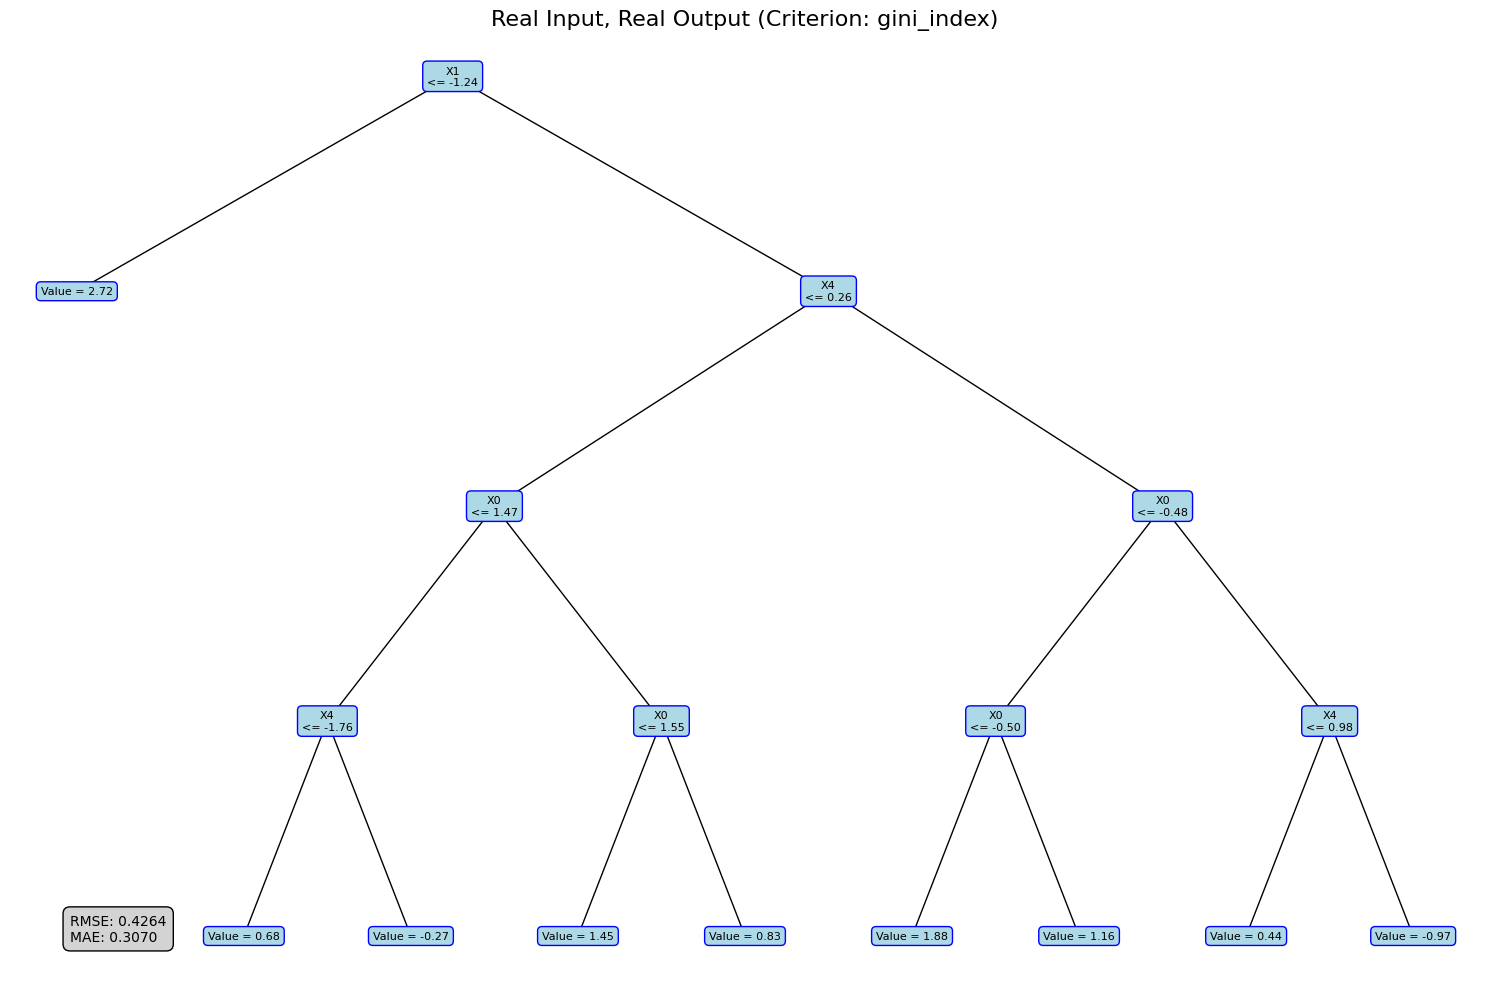


--- Real Input, Real Output (Criterion: gini_index) ---
RMSE:  0.426442114449805
MAE:  0.30700279356730054


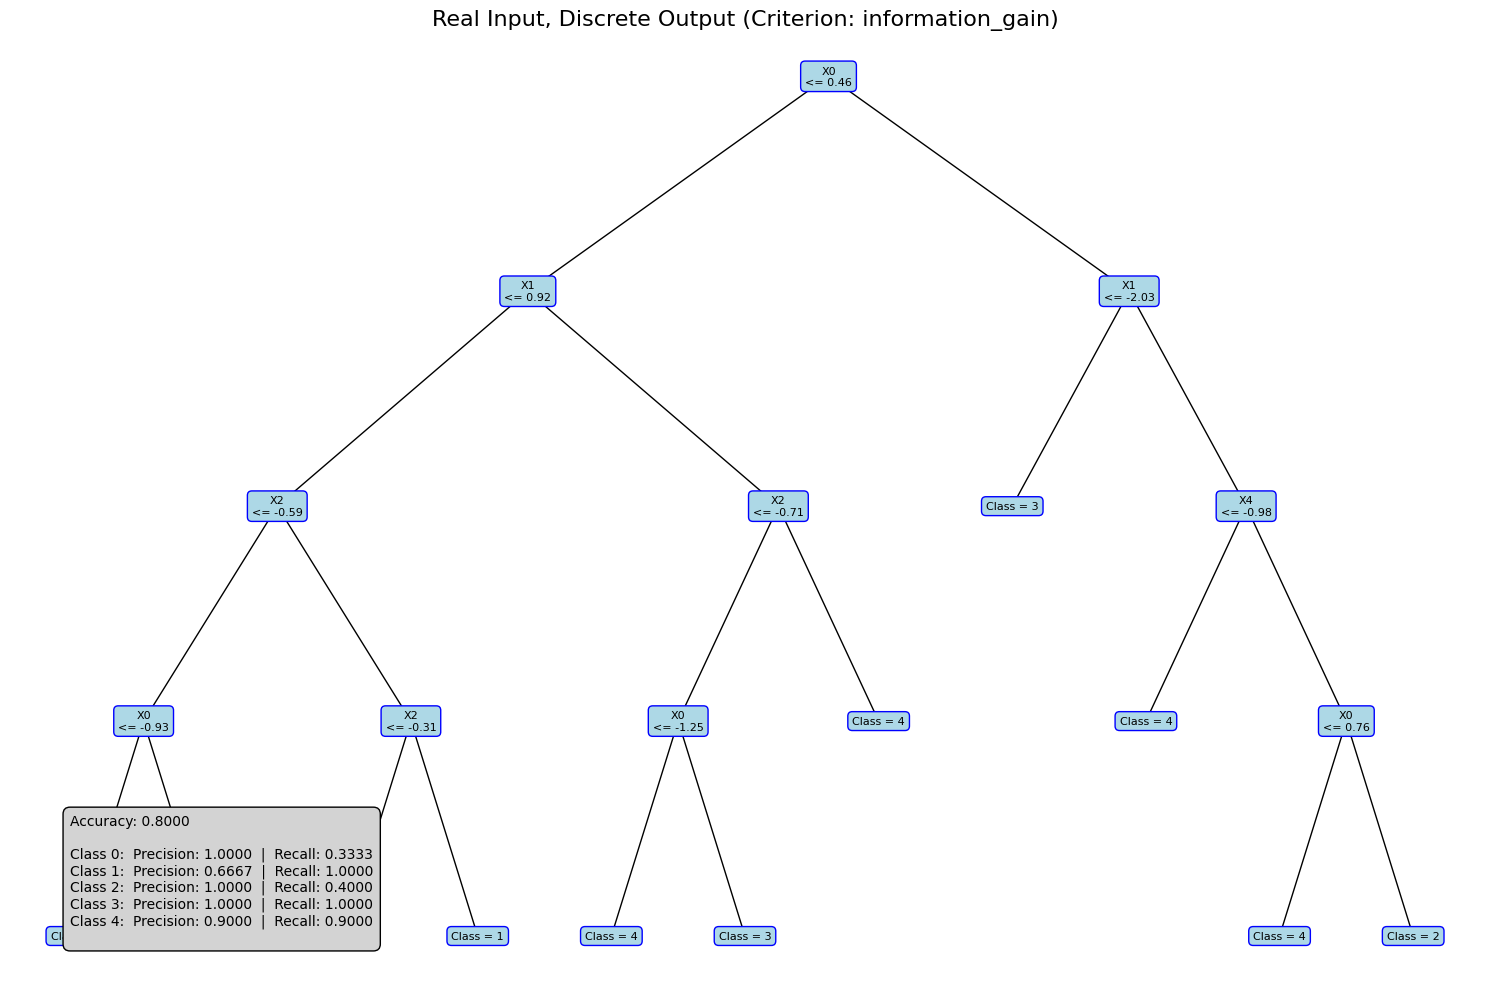


--- Real Input, Discrete Output (Criterion: information_gain) ---
Accuracy:  0.8
Class 4: Precision: 0.9000, Recall: 0.9000
Class 1: Precision: 0.6667, Recall: 1.0000
Class 2: Precision: 1.0000, Recall: 0.4000
Class 3: Precision: 1.0000, Recall: 1.0000
Class 0: Precision: 1.0000, Recall: 0.3333


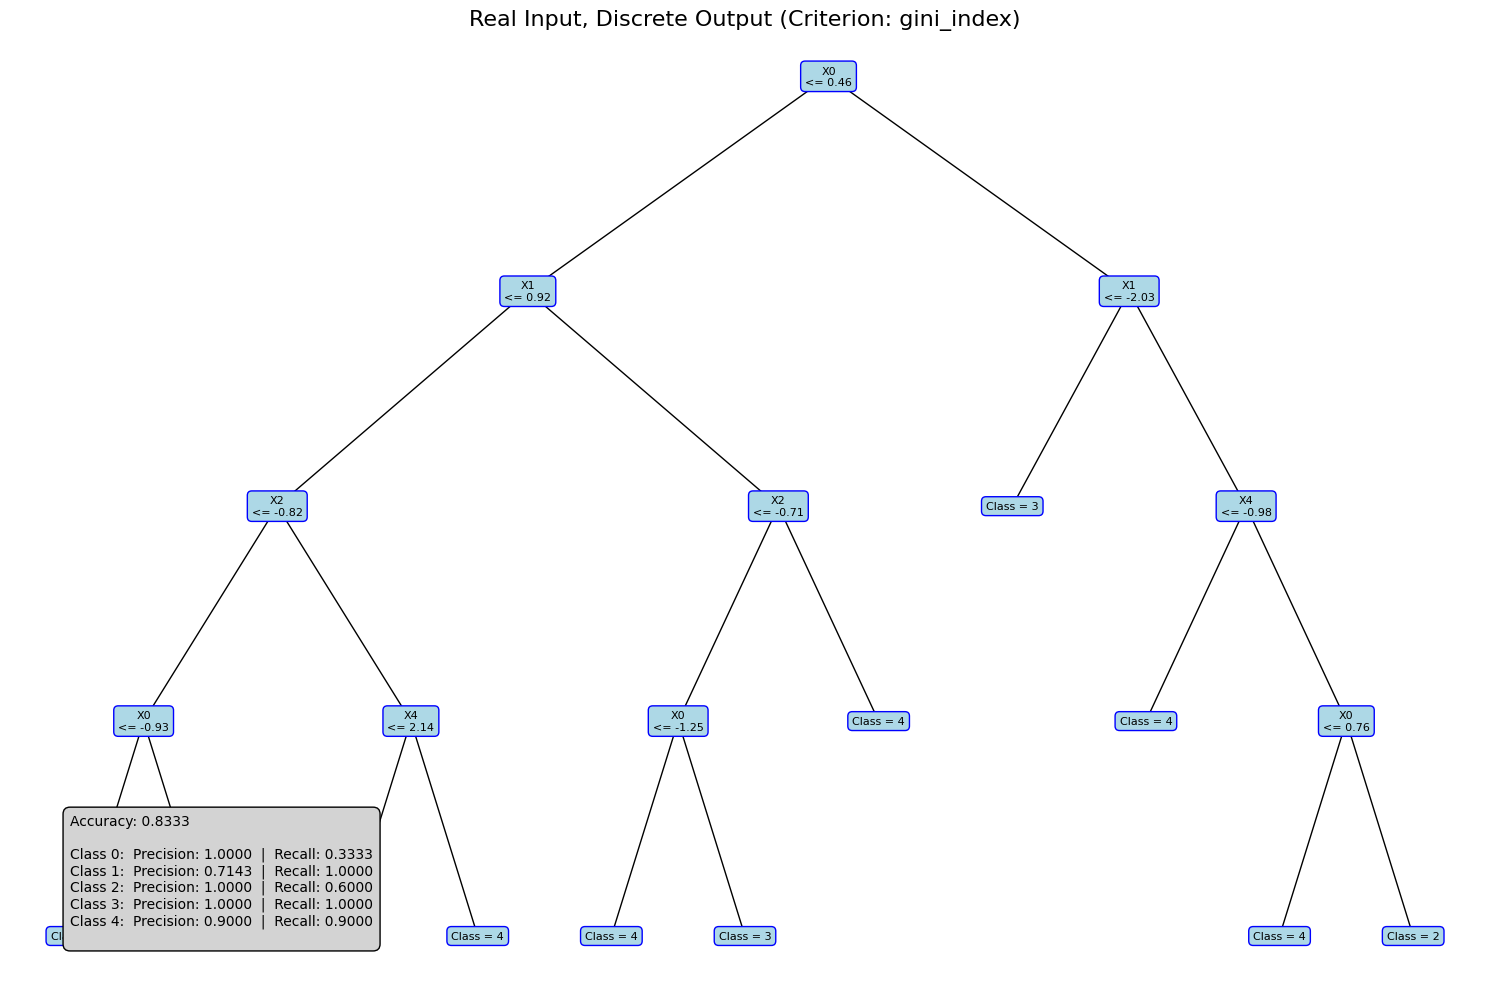


--- Real Input, Discrete Output (Criterion: gini_index) ---
Accuracy:  0.8333333333333334
Class 4: Precision: 0.9000, Recall: 0.9000
Class 1: Precision: 0.7143, Recall: 1.0000
Class 2: Precision: 1.0000, Recall: 0.6000
Class 3: Precision: 1.0000, Recall: 1.0000
Class 0: Precision: 1.0000, Recall: 0.3333


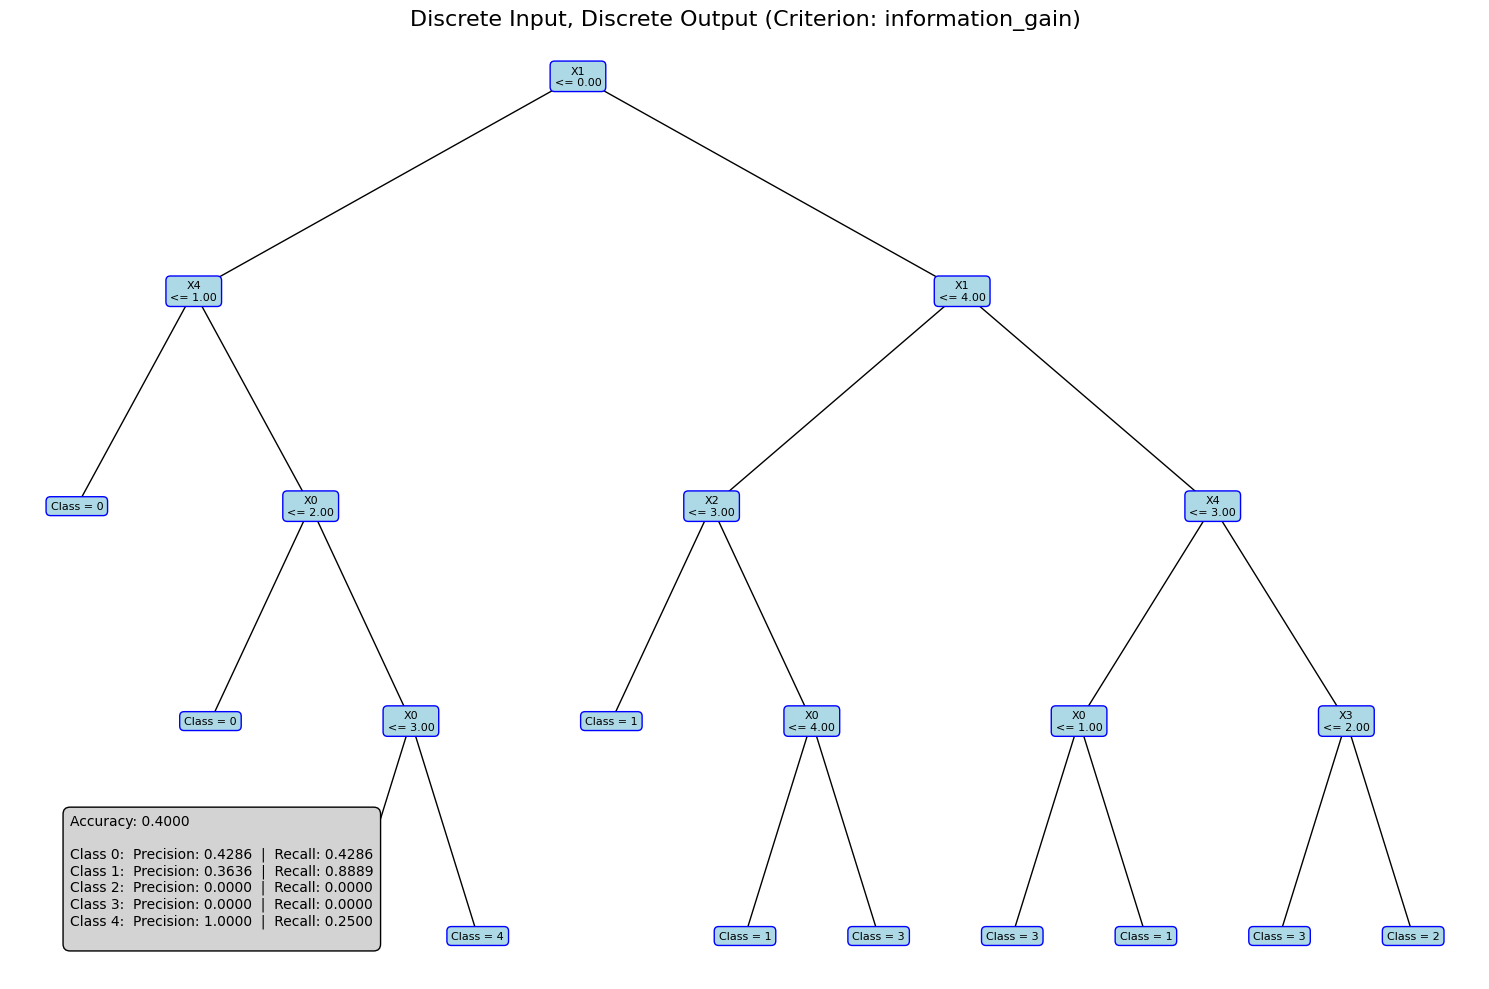


--- Discrete Input, Discrete Output (Criterion: information_gain) ---
Accuracy:  0.4
Class 0: Precision: 0.4286, Recall: 0.4286
Class 4: Precision: 1.0000, Recall: 0.2500
Class 1: Precision: 0.3636, Recall: 0.8889
Class 2: Precision: 0.0000, Recall: 0.0000
Class 3: Precision: 0.0000, Recall: 0.0000


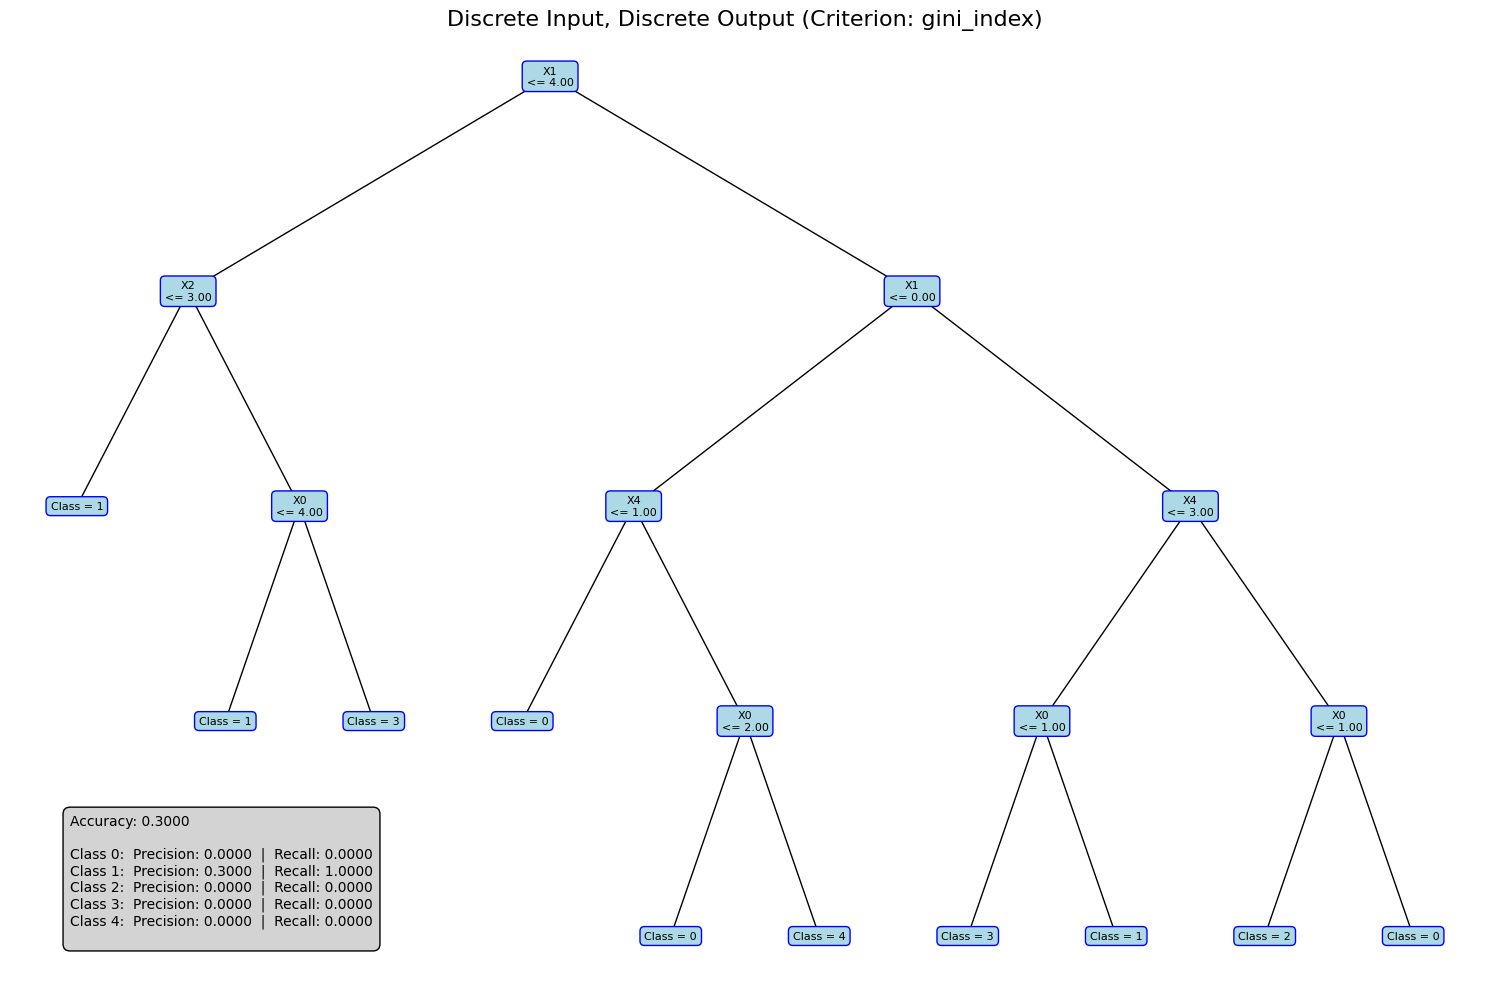


--- Discrete Input, Discrete Output (Criterion: gini_index) ---
Accuracy:  0.3
Class 0: Precision: 0.0000, Recall: 0.0000
Class 4: Precision: 0.0000, Recall: 0.0000
Class 1: Precision: 0.3000, Recall: 1.0000
Class 2: Precision: 0.0000, Recall: 0.0000
Class 3: Precision: 0.0000, Recall: 0.0000


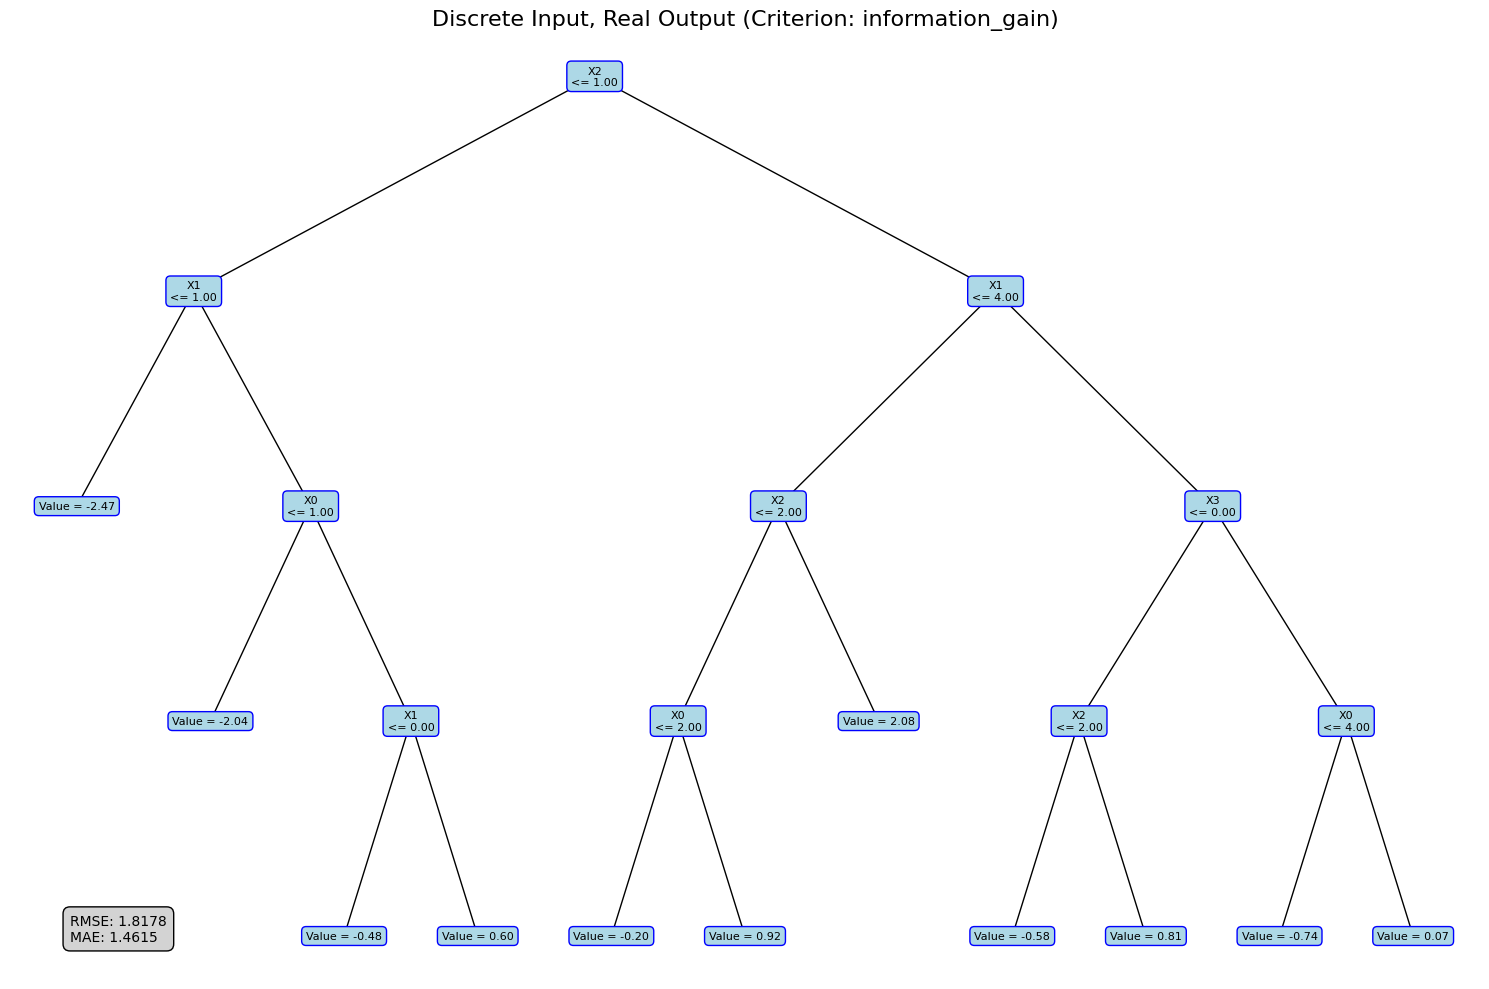


--- Discrete Input, Real Output (Criterion: information_gain) ---
RMSE:  1.817814051300298
MAE:  1.4615122014101751


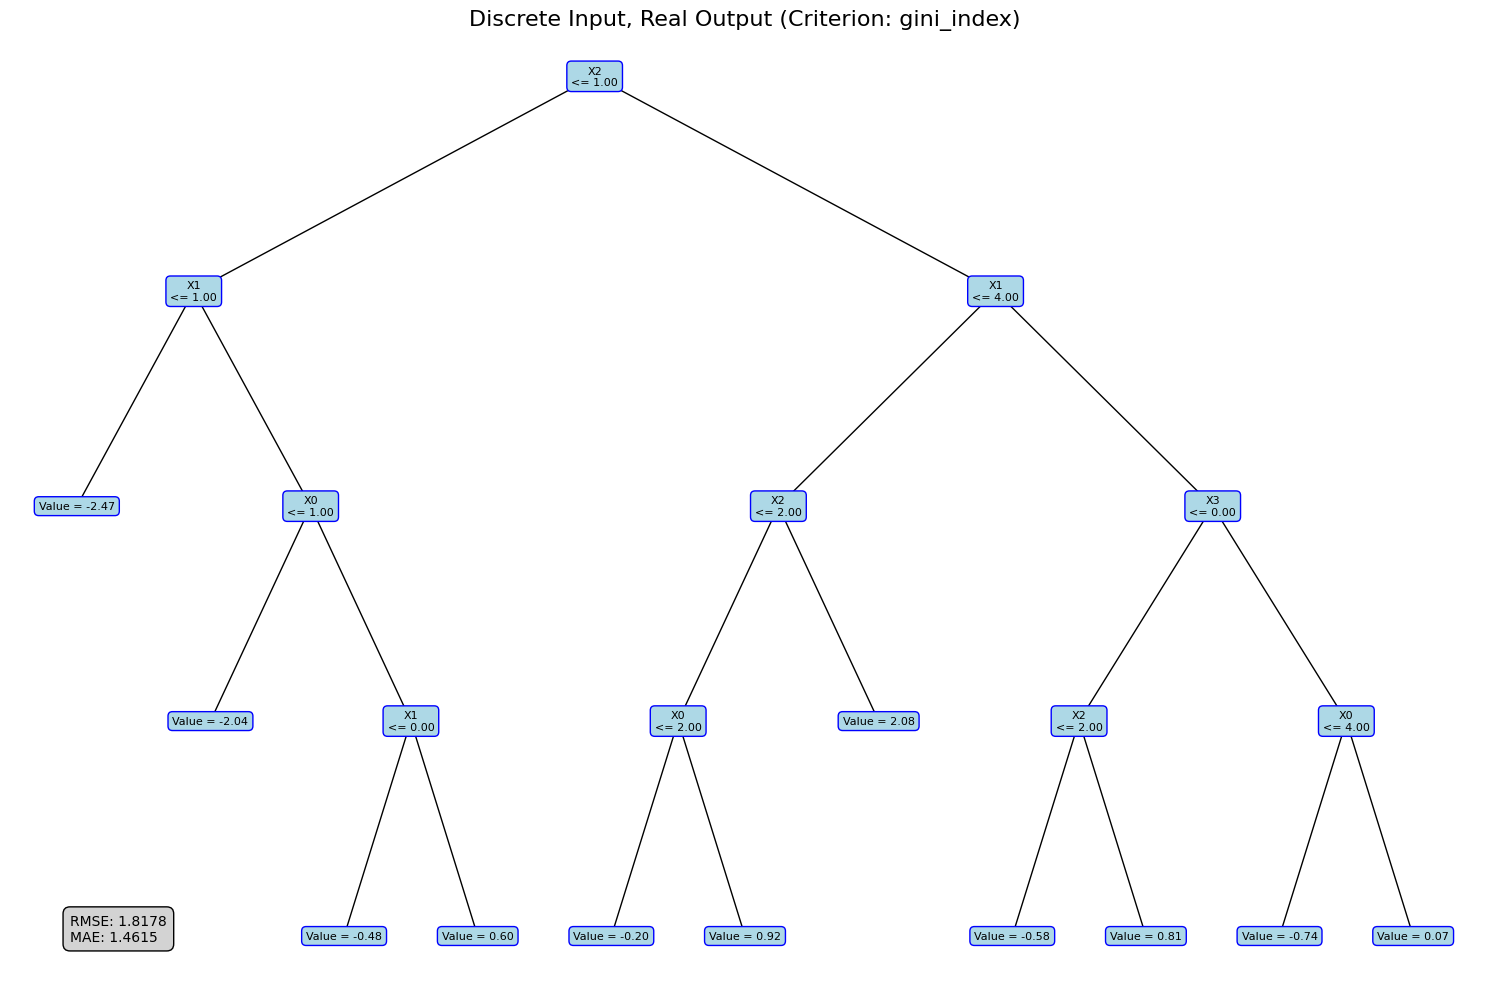


--- Discrete Input, Real Output (Criterion: gini_index) ---
RMSE:  1.817814051300298
MAE:  1.4615122014101751


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


np.random.seed(42)

# Test case 1: Real Input and Real Output
N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P), columns=[f'X{i}' for i in range(P)])
y = pd.Series(np.random.randn(N))

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria, max_depth=4)
    tree.fit(X, y)
    y_hat = tree.predict(X)

    rmse_val = rmse(y_hat, y)
    mae_val = mae(y_hat, y)

    title = f"Real Input, Real Output (Criterion: {criteria})"
    metrics_str = f"RMSE: {rmse_val:.4f}\nMAE: {mae_val:.4f}"

    tree.plot(title=title, metrics_text=metrics_str)

    print(f"\n--- {title} ---")
    print("RMSE: ", rmse_val)
    print("MAE: ", mae_val)

# Test case 2: Real Input and Discrete Output
N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P), columns=[f'X{i}' for i in range(P)])
y = pd.Series(np.random.randint(P, size=N), dtype="category")

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria, max_depth=4)
    tree.fit(X, y)
    y_hat = tree.predict(X)

    acc = accuracy(y_hat, y)
    metrics_str = f"Accuracy: {acc:.4f}\n\n"
    for cls in sorted(y.unique()):
        prec = precision(y_hat, y, cls)
        rec = recall(y_hat, y, cls)
        metrics_str += f"Class {cls}:  Precision: {prec:.4f}  |  Recall: {rec:.4f}\n"

    title = f"Real Input, Discrete Output (Criterion: {criteria})"
    tree.plot(title=title, metrics_text=metrics_str)

    print(f"\n--- {title} ---")
    print("Accuracy: ", acc)
    for cls in y.unique():
        print(f"Class {cls}: Precision: {precision(y_hat, y, cls):.4f}, Recall: {recall(y_hat, y, cls):.4f}")

# Test case 3: Discrete Input and Discrete Output
N = 30
P = 5
X = pd.DataFrame({f'X{i}': pd.Series(np.random.randint(P, size=N), dtype="category") for i in range(5)})
y = pd.Series(np.random.randint(P, size=N), dtype="category")

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria, max_depth=4)
    tree.fit(X, y)
    y_hat = tree.predict(X)

    acc = accuracy(y_hat, y)
    metrics_str = f"Accuracy: {acc:.4f}\n\n"
    for cls in sorted(y.unique()):
        prec = precision(y_hat, y, cls)
        rec = recall(y_hat, y, cls)
        metrics_str += f"Class {cls}:  Precision: {prec:.4f}  |  Recall: {rec:.4f}\n"

    title = f"Discrete Input, Discrete Output (Criterion: {criteria})"
    tree.plot(title=title, metrics_text=metrics_str)

    print(f"\n--- {title} ---")
    print("Accuracy: ", acc)
    for cls in y.unique():
        print(f"Class {cls}: Precision: {precision(y_hat, y, cls):.4f}, Recall: {recall(y_hat, y, cls):.4f}")

# Test case 4: Discrete Input and Real Output
N = 30
P = 5
X = pd.DataFrame({f'X{i}': pd.Series(np.random.randint(P, size=N), dtype="category") for i in range(5)})
y = pd.Series(np.random.randn(N))

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria, max_depth=4)
    tree.fit(X, y)
    y_hat = tree.predict(X)

    rmse_val = rmse(y_hat, y)
    mae_val = mae(y_hat, y)

    title = f"Discrete Input, Real Output (Criterion: {criteria})"
    metrics_str = f"RMSE: {rmse_val:.4f}\nMAE: {mae_val:.4f}"

    tree.plot(title=title, metrics_text=metrics_str)

    print(f"\n--- {title} ---")
    print("RMSE: ", rmse_val)
    print("MAE: ", mae_val)

#Qustions and Answers




Question 2: Classification Experiment

a) Performance on Test Set
Accuracy: 0.83
Class 1 Precision: 0.86
Class 1 Recall: 0.80
Class 0 Precision: 0.81
Class 0 Recall: 0.87

b) 5-Fold Cross-Validation

Depth	Avg. Accuracy
1	0.90
2	0.92
3	0.90
4	0.90
5	0.89
6	0.88
7	0.87
8	0.88
9	0.87
10	0.87

Optimal Depth: 2 (Accuracy = 0.92)

Analysis: Performance peaks at depth 2. Deeper trees show lower accuracy, indicating overfitting.


Question 3: Automotive Efficiency Regression

Dataset: Auto MPG (predicting fuel efficiency mpg).

a) Custom Decision Tree Performance

RMSE: 3.31
MAE: 2.29

b) Scikit-learn Decision Tree Performance

RMSE: 10.13
MAE: 8.52

Analysis: The custom implementation significantly outperformed scikit-learn’s version in this experiment (with max_depth=5). This may be due to the simpler splitting strategy coincidentally finding more effective splits for the given train-test split (random_state=42).


Question 4: Runtime Complexity Analysis



Theoretical Complexity:
Training (Fit): O(M · N · log N)
Prediction (Predict): O(N · D) (D = tree depth)


Experimental Results:

Fit vs. N: Super-linear growth, consistent with N log N.
Predict vs. N: Linear growth, consistent with O(N).
Fit vs. M: Linear growth, consistent with O(M).
Predict vs. M: Flat (independent of features).


Conclusion: Experimental results match theoretical complexity.

#Human Activity Recognition (HAR)

In [ ]:

!pip install gdown

import gdown
import zipfile
import os

# Google Drive file ID
file_id = '1ApUw-nmznMLHZ8zEnCWri8Ur1G9fOd3i'

# Output path for the downloaded file
output = 'UCI_HAR_Dataset.zip'

# Download the file
gdown.download(id=file_id, output=output, quiet=False)

# Unzip the file
if os.path.exists(output):
    with zipfile.ZipFile(output, 'r') as zf:
        zf.extractall()
    print("File downloaded and unzipped successfully.")
else:
    print("File download failed.")

Downloading...
From (original): https://drive.google.com/uc?id=1ApUw-nmznMLHZ8zEnCWri8Ur1G9fOd3i
From (redirected): https://drive.google.com/uc?id=1ApUw-nmznMLHZ8zEnCWri8Ur1G9fOd3i&confirm=t&uuid=ca520368-7f5c-46c0-bd95-c636a58bf72f
To: /content/UCI_HAR_Dataset.zip
100%|██████████| 61.0M/61.0M [00:00<00:00, 76.8MB/s]


File downloaded and unzipped successfully.


In [ ]:
#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
#                                   ES335- Machine Learning- Assignment 1
#
# This script combines the data from the UCI HAR Dataset into a more usable format.
# The data is combined into a single csv file for each subject and activity.
# The data is then stored in the Combined folder.
#
#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# Library imports
import pandas as pd
import numpy as np
import os

# Give the path of the test and train folder of UCI HAR Dataset
train_path = "./UCI HAR Dataset/train"
test_path = "./UCI HAR Dataset/test"

# Dictionary of activities. Provided by the dataset.
ACTIVITIES = {
    1: 'WALKING'            ,
    2: 'WALKING_UPSTAIRS'   ,
    3: 'WALKING_DOWNSTAIRS' ,
    4: 'SITTING'            ,
    5: 'STANDING'           ,
    6: 'LAYING'             ,
}

#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
                                        # Combining Traing Data
#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# Load all the accelerometer data
total_acc_x = pd.read_csv(os.path.join(train_path,"Inertial Signals","total_acc_x_train.txt"),delim_whitespace=True,header=None)
total_acc_y = pd.read_csv(os.path.join(train_path,"Inertial Signals","total_acc_y_train.txt"),delim_whitespace=True,header=None)
total_acc_z = pd.read_csv(os.path.join(train_path,"Inertial Signals","total_acc_z_train.txt"),delim_whitespace=True,header=None)


# Read the subject IDs
subject_train = pd.read_csv(os.path.join(train_path,"subject_train.txt"),delim_whitespace=True,header=None)

# Read the labels
y = pd.read_csv(os.path.join(train_path,"y_train.txt"),delim_whitespace=True,header=None)


# Toggle through all the subjects.
for subject in np.unique(subject_train.values):

    sub_idxs = np.where( subject_train.iloc[:,0] == subject )[0]
    labels = y.loc[sub_idxs]

    # Toggle through all the labels.
    for label in np.unique(labels.values):

        # make the folder directory if it does not exist
        if not os.path.exists(os.path.join("Combined","Train",ACTIVITIES[label])):
            os.makedirs(os.path.join("Combined","Train",ACTIVITIES[label]))

        label_idxs = labels[labels.iloc[:,0] == label].index

        accx = []
        accy = []
        accz = []

        for idx in label_idxs:
            if accx is not None:
                accx = np.hstack((accx,total_acc_x.loc[idx][64:]))
                accy = np.hstack((accy,total_acc_y.loc[idx][64:]))
                accz = np.hstack((accz,total_acc_z.loc[idx][64:]))

            else:
                accx = total_acc_x.loc[idx]
                accy = total_acc_y.loc[idx]
                accz = total_acc_z.loc[idx]

        # saving the data into csv file
        data = pd.DataFrame({'accx':accx,'accy':accy,'accz':accz})
        save_path = os.path.join("Combined","Train",ACTIVITIES[label],f"Subject_{subject}.csv")
        data.to_csv(save_path,index=False)

print("Done Combining the training data")


#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
                                        # Combining Test Data
#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# Load all the accelerometer data
total_acc_x = pd.read_csv(os.path.join(test_path,"Inertial Signals","total_acc_x_test.txt"),delim_whitespace=True,header=None)
total_acc_y = pd.read_csv(os.path.join(test_path,"Inertial Signals","total_acc_y_test.txt"),delim_whitespace=True,header=None)
total_acc_z = pd.read_csv(os.path.join(test_path,"Inertial Signals","total_acc_z_test.txt"),delim_whitespace=True,header=None)

# Read the subject IDs
subject_test = pd.read_csv(os.path.join(test_path,"subject_test.txt"),delim_whitespace=True,header=None)

# Read the labels
y = pd.read_csv(os.path.join(test_path,"y_test.txt"),delim_whitespace=True,header=None)

# Toggle through all the subjects.
for subject in np.unique(subject_test.values):

        sub_idxs = np.where( subject_test.iloc[:,0] == subject )[0]
        labels = y.loc[sub_idxs]

        # Toggle through all the labels.
        for label in np.unique(labels.values):

            if not os.path.exists(os.path.join("Combined","Test",ACTIVITIES[label])):
                os.makedirs(os.path.join("Combined","Test",ACTIVITIES[label]))

            label_idxs = labels[labels.iloc[:,0] == label].index

            accx = []
            accy = []
            accz = []
            for idx in label_idxs:
                if accx is not None:
                    accx = np.hstack((accx,total_acc_x.loc[idx][64:]))
                    accy = np.hstack((accy,total_acc_y.loc[idx][64:]))
                    accz = np.hstack((accz,total_acc_z.loc[idx][64:]))

                else:
                    accx = total_acc_x.loc[idx]
                    accy = total_acc_y.loc[idx]
                    accz = total_acc_z.loc[idx]

            # saving the data into csv file
            data = pd.DataFrame({'accx':accx,'accy':accy,'accz':accz})
            save_path = os.path.join("Combined","Test",ACTIVITIES[label],f"Subject_{subject}.csv")
            data.to_csv(save_path,index=False)

print("Done Combining the testing data")
print("Done Combining the data")

#-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

/tmp/ipython-input-2713426267.py:35: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  total_acc_x = pd.read_csv(os.path.join(train_path,"Inertial Signals","total_acc_x_train.txt"),delim_whitespace=True,header=None)
/tmp/ipython-input-2713426267.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  total_acc_y = pd.read_csv(os.path.join(train_path,"Inertial Signals","total_acc_y_train.txt"),delim_whitespace=True,header=None)
/tmp/ipython-input-2713426267.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  total_acc_z = pd.read_csv(os.path.join(train_path,"Inertial Signals","total_acc_z_train.txt"),delim_whitespace=True,header=None)
/tmp/ipython-input-2713426267.py:41: FutureWarning: The 'delim_whitesp

Done Combining the training data


/tmp/ipython-input-2713426267.py:90: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  total_acc_x = pd.read_csv(os.path.join(test_path,"Inertial Signals","total_acc_x_test.txt"),delim_whitespace=True,header=None)
/tmp/ipython-input-2713426267.py:91: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  total_acc_y = pd.read_csv(os.path.join(test_path,"Inertial Signals","total_acc_y_test.txt"),delim_whitespace=True,header=None)
/tmp/ipython-input-2713426267.py:92: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  total_acc_z = pd.read_csv(os.path.join(test_path,"Inertial Signals","total_acc_z_test.txt"),delim_whitespace=True,header=None)
/tmp/ipython-input-2713426267.py:95: FutureWarning: The 'delim_whitespace' k

Done Combining the testing data
Done Combining the data


In [ ]:
#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
#                                   ES335- Machine Learning- Assignment 1
#
# This file is used to create the dataset for the mini-project. The dataset is created by reading the data from
# the Combined folder. The data is then split into training, testing, and validation sets. This split is supposed
# to be used for all the modeling purposes.
#
#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# Library imports
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

# Constants
time = 10
offset = 100
folders = ["LAYING","SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIRS"]
classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}

combined_dir = os.path.join("Combined")

#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
                                                # Train Dataset
#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

X_train=[]
y_train=[]
dataset_dir = os.path.join(combined_dir,"Train")

for folder in folders:
    files = os.listdir(os.path.join(dataset_dir,folder))

    for file in files:

        df = pd.read_csv(os.path.join(dataset_dir,folder,file),sep=",",header=0)
        df = df[offset:offset+time*50]
        X_train.append(df.values)
        y_train.append(classes[folder])

X_train = np.array(X_train)
y_train = np.array(y_train)


#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
                                                # Test Dataset
#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

X_test=[]
y_test=[]
dataset_dir = os.path.join(combined_dir,"Test")

for folder in folders:
    files = os.listdir(os.path.join(dataset_dir,folder))
    for file in files:

        df = pd.read_csv(os.path.join(dataset_dir,folder,file),sep=",",header=0)
        df = df[offset:offset+time*50]
        X_test.append(df.values)
        y_test.append(classes[folder])

X_test = np.array(X_test)
y_test = np.array(y_test)

#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
                                                # Final Dataset
#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# USE THE BELOW GIVEN DATA FOR TRAINING and TESTING purposes

# concatenate the training and testing data
X = np.concatenate((X_train,X_test))
y = np.concatenate((y_train,y_test))

# split the data into training and testing sets. Change the seed value to obtain different random splits.
seed = 4
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=seed,stratify=y)

print("Training data shape: ",X_train.shape)
print("Testing data shape: ",X_test.shape)

#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=



Training data shape:  (126, 500, 3)
Testing data shape:  (54, 500, 3)


TASK 1 HAR

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
train_data = os.path.join('./Combined/Train')
test_data = os.path.join('./Combined/Test')

In [ ]:
activities = ['LAYING', 'SITTING', 'STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]
for activity in activities:
    folder = os.path.join(train_data,activity)
    data = os.listdir(folder)
    # print(len(data))
    for csv in data:
        df=pd.read_csv(os.path.join(train_data,activity,csv),header=0)
        x_train.append(df.values[:500])
        y_train.append(activity)
for activity in activities:
    folder = os.path.join(test_data,activity)
    data = os.listdir(folder)
    # print(len(data))
    for csv in data:
        df=pd.read_csv(os.path.join(test_data,activity,csv),header=0)
        x_test.append(df.values[:500])
        y_test.append(activity)

In [ ]:
x_train=np.array(x_train)
y_train=np.array(y_train)
print(f"Shape of X_train = {x_train.shape}")
print(f'Shape of y_train = {y_train.shape}')

x_test=np.array(x_test)
y_test=np.array(y_test)
print(f"Shape of X_test = {x_test.shape}")
print(f'Shape of y_test = {y_test.shape}')

Shape of X_train = (126, 500, 3)
Shape of y_train = (126,)
Shape of X_test = (54, 500, 3)
Shape of y_test = (54,)


Q1 Plot the waveform for one sample data from each activity class. Are you able to see any difference/similarities between the activities? You can plot a subplot having 6 columns to show differences/similarities between the activities. Do you think the model will be able to classify the activities based on the data? [0.5 marks]

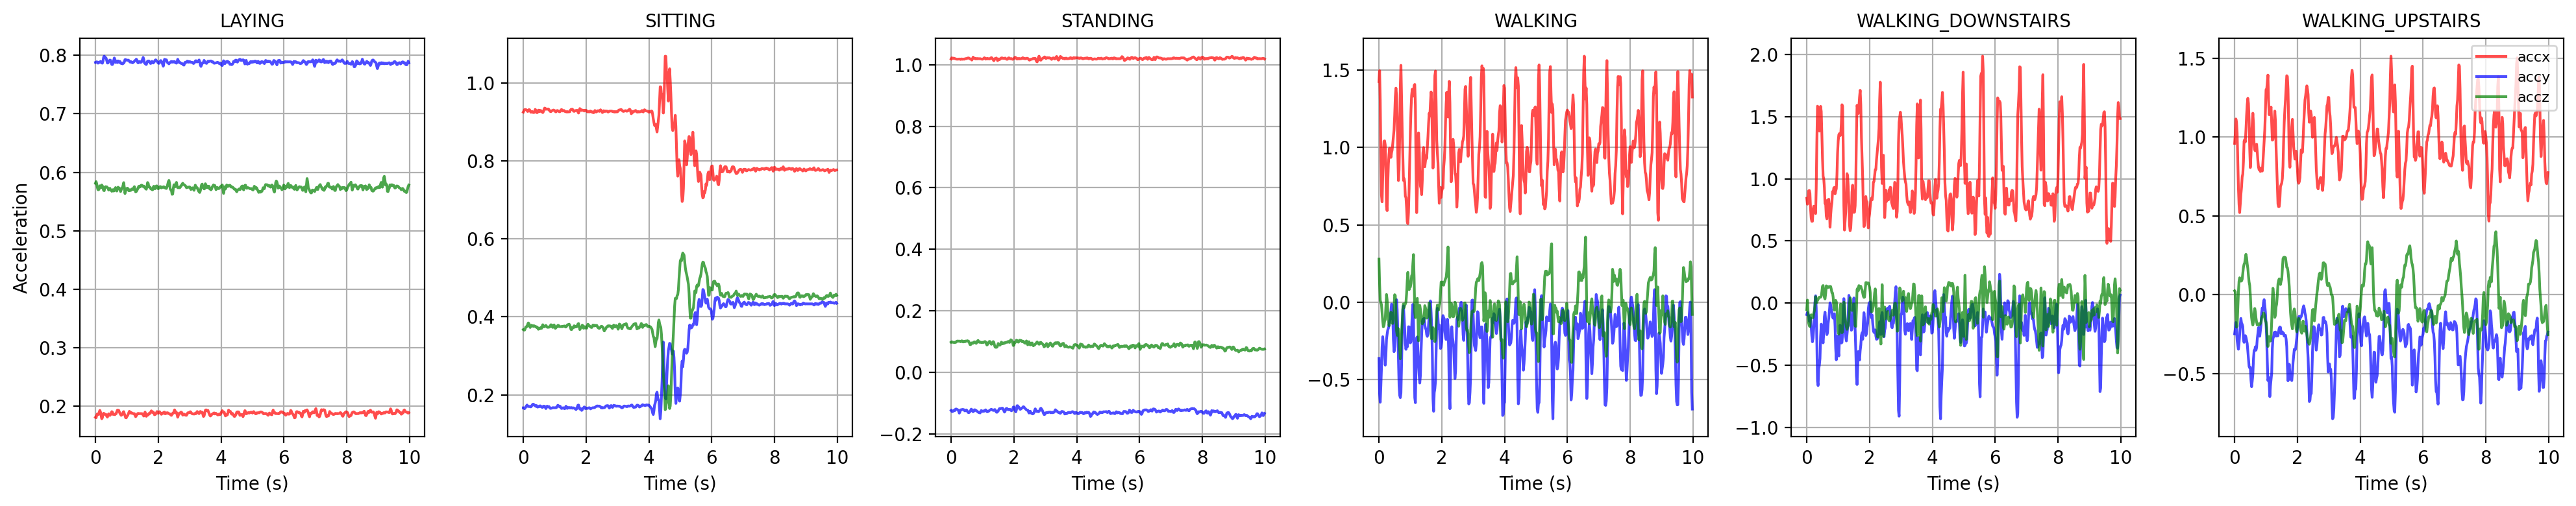

In [ ]:
activities = ["LAYING", "SITTING", "STANDING",
              "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]


freq = 50
n = 500

plt.figure(figsize=(20, 4))

for i, activity in enumerate(activities):
    df = pd.read_csv(f"Combined/Train/{activity}/Subject_1.csv").iloc[:n]
    time = np.arange(len(df)) / freq

    plt.subplot(1, 6, i+1)
    plt.plot(time, df["accx"], label="accx", color="r", alpha=0.7)
    plt.plot(time, df["accy"], label="accy", color="b", alpha=0.7)
    plt.plot(time, df["accz"], label="accz", color="g", alpha=0.7)

    plt.title(activity, fontsize=10)
    plt.xlabel("Time (s)")
    if i == 0:
        plt.ylabel("Acceleration")
    plt.grid(True)
    if i == 5:
        plt.legend(loc="upper right", fontsize=8)

plt.tight_layout()
plt.show()

The differences/similarities between the various activities are:

The variation in the accelerometer values of static acitivities like laying, sitting, and standing is much less than dynamic activities like walking, walking_upstairs and walking_downstairs. The accelerometer readings are much different in the static activities (for example, acc x for laying is in the range (0.18,0.19), for sitting (0.7,1.05) and for standing (1.01,1.02) whereas its almost same for dynamic activities (0.6,1.5))

Yes, the model could classify the distinction between static and dynamic activities very clearly. Yet, it may face some difficulty in classifying among the different static and dynamic activities.

Q2 Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities (walking, walking_downstairs, walking_upstairs)?

Look at the linear acceleration:

[ a_{mag} = \sqrt{acc_x^2 + acc_y^2 + acc_z^2} ]

for each activity and justify your answer. [0.5 marks]

In [ ]:
total_acceleration = x_train[:,:,0]**2 + x_train[:,:,1]**2 + x_train[:,:,2]**2
total_acceleration_x_test = x_test[:,:,0]**2 + x_test[:,:,1]**2 + x_test[:,:,2]**2
for i in range(len(activities)):
    activity=activities[i]
    var_ = total_acceleration[i*21].var()
    mean_ = total_acceleration[i*21].mean()
    print(f"Mean total acceleration for activity {activity} = {mean_}")
    print(f"Variance in  total acceleration for activity {activity} = {var_}")

Mean total acceleration for activity LAYING = 1.0173545023409767
Variance in  total acceleration for activity LAYING = 0.00010205572045976707
Mean total acceleration for activity SITTING = 1.0465402278382336
Variance in  total acceleration for activity SITTING = 6.459791095313781e-05
Mean total acceleration for activity STANDING = 1.0556345681959554
Variance in  total acceleration for activity STANDING = 0.00037823382554365775
Mean total acceleration for activity WALKING = 1.1641451156369802
Variance in  total acceleration for activity WALKING = 0.28143999239115103
Mean total acceleration for activity WALKING_DOWNSTAIRS = 1.186554052652505
Variance in  total acceleration for activity WALKING_DOWNSTAIRS = 0.663661616765753
Mean total acceleration for activity WALKING_UPSTAIRS = 1.1614232314208484
Variance in  total acceleration for activity WALKING_UPSTAIRS = 0.2506061206082746


No, we don't really need a machine learning model to distinguish between static and dynamic activities. We can classify them seperately just be setting some threshold on mean or variance or some other property as these numbers vary to a great extent between static and dynamic activities.

In [ ]:
total_acceleration.shape

(126, 500)

In [ ]:
total_acceleration_test = x_test[:,:,0]**2 + x_test[:,:,1]**2 + x_test[:,:,2]**2
print(total_acceleration_test.shape)

(54, 500)


Q3 Visualize the data using PCA. [1 marks]

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca.fit(total_acceleration)
pca_data = pca.transform(total_acceleration)
pca_data.shape


(126, 2)

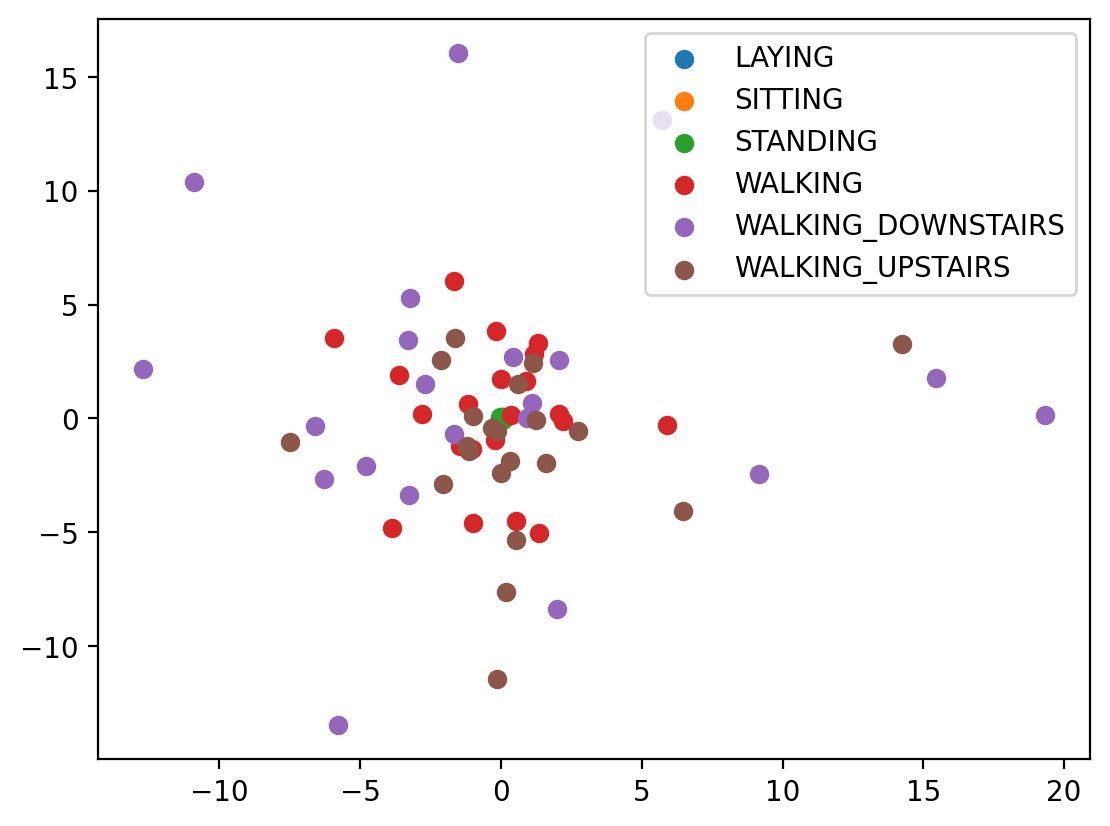

In [ ]:
for i in range(len(activities)):
    activity = activities[i]
    plt.scatter(pca_data[i*21:(i+1)*21,0],pca_data[i*21:(i+1)*21,1],label=activity)
    plt.legend()

Featurization using TSFEL

In [ ]:
pip install tsfel -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.7 MB/s eta 0:00:00


In [ ]:
import tsfel
from tsfel.feature_extraction.features import calc_mean, calc_var, pk_pk_distance, mean_abs_deviation, auc, autocorr

In [ ]:
def extract_features(data):
    tsfel_features=[]
    for i in range(len(data)):
        mean = calc_mean(data[i])
        var = calc_var(data[i])
        dist = pk_pk_distance(data[i])
        mad = mean_abs_deviation(data[i])
        corr = autocorr(data[i])
        auc_ = auc(data[i],50)
        tsfel_features.append([mean,var,dist,mad,corr,auc_])
    return tsfel_features

In [ ]:
tsfel_features_train=np.array(extract_features(total_acceleration))
tsfel_features_test=np.array(extract_features(total_acceleration_test))

In [ ]:
print(tsfel_features_train.shape)
print(tsfel_features_test.shape)

(126, 6)
(54, 6)


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca.fit(tsfel_features_train)
tsfel_pca_data = pca.transform(tsfel_features_train)
tsfel_pca_data.shape

(126, 2)

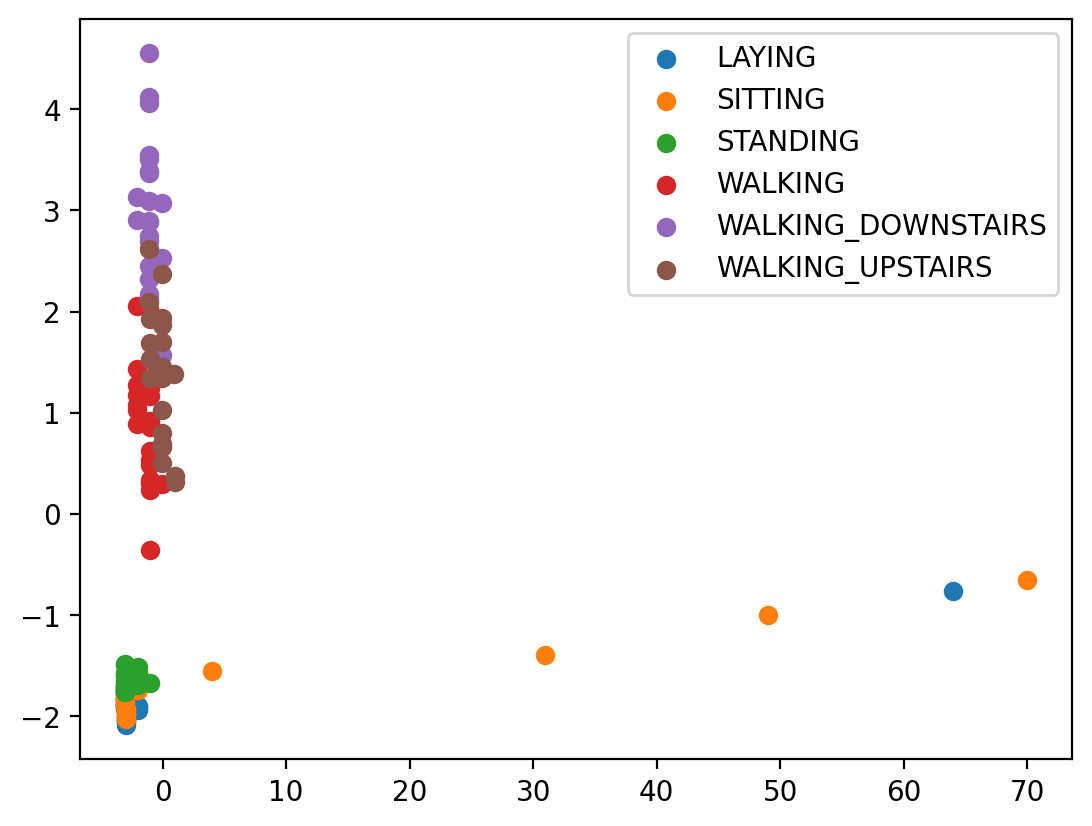

In [ ]:
for i in range(len(activities)):
    activity = activities[i]
    plt.scatter(tsfel_pca_data[i*21:(i+1)*21,0],tsfel_pca_data[i*21:(i+1)*21,1],label=activity)
    plt.legend()

PCA on features provided in dataset

In [ ]:
X_train_features = np.loadtxt('UCI HAR Dataset/train/X_train.txt')
X_train_features.shape

(7352, 561)

In [ ]:
y_train_features = np.loadtxt('UCI HAR Dataset/train/y_train.txt')
y_train_features.shape

(7352,)

In [ ]:
pca = PCA(n_components=2, random_state=42)
pca.fit(X_train_features)
X_train_pca_data = pca.transform(X_train_features)
X_train_pca_data.shape

(7352, 2)

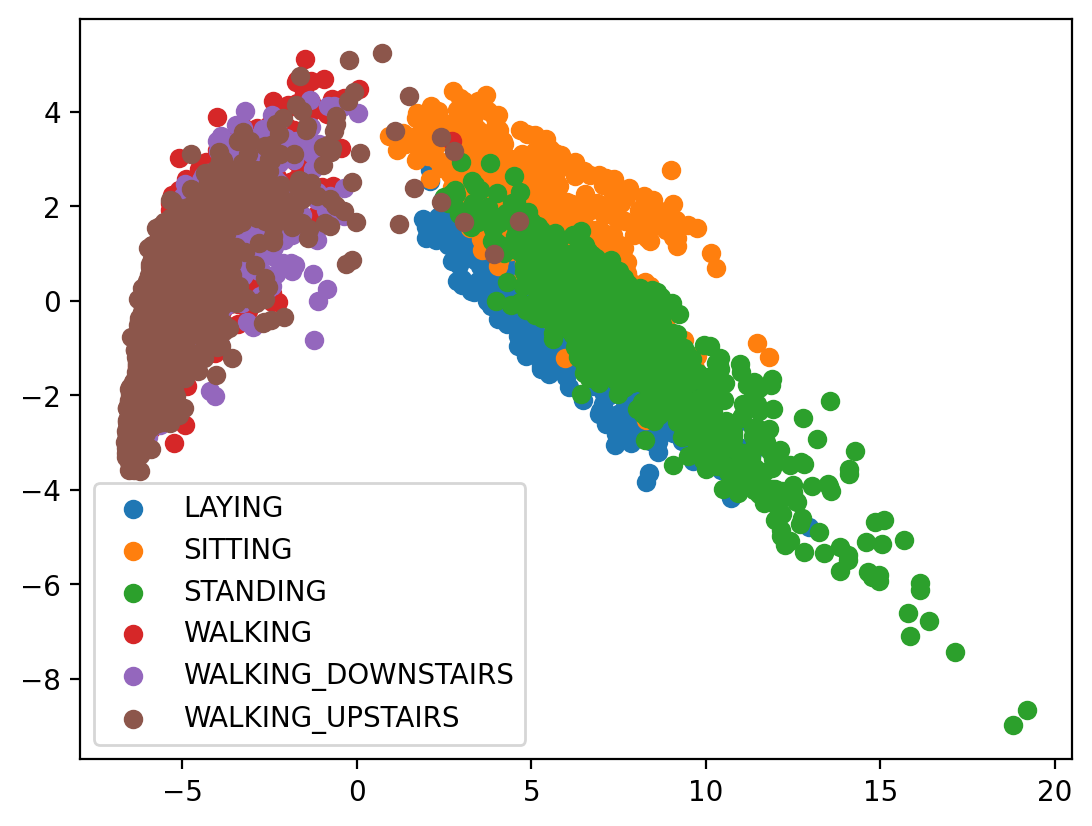

In [ ]:
for i in range(1,7):
    plt.scatter(X_train_pca_data[y_train_features==i,0],X_train_pca_data[y_train_features==i,1],label=activities[i-1])
    plt.legend()

The PCA on the total_acceleration is very scattered and the different activities have very high overlapping region in that graph.
Whereas, the PCA on TSFEL featurized data and on features provided in the data have better plots as different activities can be clearly distinguished in different clusters with less overlap.
Either of the TSFEL or dataset provided by the features is good for visualising the data.

Q4 Calculate the correlation matrix of the features obtained by TSFEL and provided in the dataset. Identify the features that are highly correlated with each other. Are there any redundant features? [1 marks]

In [ ]:
os.listdir()
features = np.loadtxt('UCI HAR Dataset/features.txt',dtype=str)
features = features[:, 1]

In [ ]:
tsfel_features_train_df = pd.DataFrame(tsfel_features_train,columns=['mean','var','dist','mad','corr','auc'])
dataset_features_train_df = pd.DataFrame(X_train_features,columns=features)

In [ ]:
tsfel_features_train_df.corr()

,mean,var,dist,mad,corr,auc
mean,1.000000,0.906074,0.940925,0.963414,-0.091050,0.999958
var,0.906074,1.000000,0.908139,0.947084,-0.063738,0.906380
dist,0.940925,0.908139,1.000000,0.974450,-0.069124,0.941345
mad,0.963414,0.947084,0.974450,1.000000,-0.067565,0.963569
corr,-0.091050,-0.063738,-0.069124,-0.067565,1.000000,-0.091031
auc,0.999958,0.906380,0.941345,0.963569,-0.091031,1.000000


In [ ]:
dataset_features_train_df.corr()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
tBodyAcc-mean()-X,1.000000,0.148061,-0.256952,0.000619,-0.021903,-0.044617,0.006290,-0.022754,-0.047558,0.044062,...,0.030681,-0.017557,-0.015613,-0.544320,0.012173,0.037444,0.028844,-0.035257,0.034371,0.028242
tBodyAcc-mean()-Y,0.148061,1.000000,-0.078769,-0.045160,-0.044920,-0.049746,-0.044180,-0.045049,-0.050402,-0.038108,...,-0.022395,-0.001587,-0.004459,0.070559,-0.013541,0.017967,0.075679,-0.005309,0.001053,-0.013903
tBodyAcc-mean()-Z,-0.256952,-0.078769,1.000000,-0.020217,-0.016641,-0.008410,-0.018747,-0.015203,-0.001988,-0.037197,...,-0.020481,0.020091,0.019127,0.052841,-0.039836,-0.063609,-0.034037,0.008587,-0.015288,-0.022643
tBodyAcc-std()-X,0.000619,-0.045160,-0.020217,1.000000,0.927461,0.851668,0.998632,0.920888,0.846392,0.980844,...,-0.065987,0.148034,0.115565,-0.035011,-0.021633,0.018985,-0.024810,-0.371653,0.471065,0.394825
tBodyAcc-std()-Y,-0.021903,-0.044920,-0.016641,0.927461,1.000000,0.895510,0.922803,0.997347,0.894509,0.917366,...,-0.105621,0.206227,0.176946,-0.020379,-0.012505,-0.008507,-0.014592,-0.380531,0.523600,0.433169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",0.037444,0.017967,-0.063609,0.018985,-0.008507,-0.018429,0.019389,-0.012546,-0.023525,0.025066,...,-0.026615,0.034514,0.024553,-0.006269,0.009141,1.000000,-0.116001,-0.005853,-0.012313,-0.019903
"angle(tBodyGyroJerkMean,gravityMean)",0.028844,0.075679,-0.034037,-0.024810,-0.014592,-0.006471,-0.024951,-0.012341,-0.007231,-0.028871,...,0.000102,-0.017937,-0.014865,-0.020823,0.035263,-0.116001,1.000000,0.023995,-0.005869,-0.005656
"angle(X,gravityMean)",-0.035257,-0.005309,0.008587,-0.371653,-0.380531,-0.345011,-0.368191,-0.377025,-0.347389,-0.384192,...,0.087332,-0.086006,-0.079751,0.011880,0.023246,-0.005853,0.023995,1.000000,-0.783848,-0.643655
"angle(Y,gravityMean)",0.034371,0.001053,-0.015288,0.471065,0.523600,0.476006,0.466424,0.525081,0.477607,0.480229,...,-0.100125,0.086993,0.078079,0.001540,-0.012990,-0.012313,-0.005869,-0.783848,1.000000,0.594885


task 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import tsfel

activities = ["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"]

Q1 Use Sklearn Library to train Decision Tress. [1.5 marks]

Train a decision tree model using the raw accelerometer data. Report the accuracy, precision, recall and confusion matrix of the model.

=== Raw Accelerometer Data Model ===
Accuracy : 0.6666666666666666
Precision: 0.6333333333333334
Recall   : 0.6666666666666666


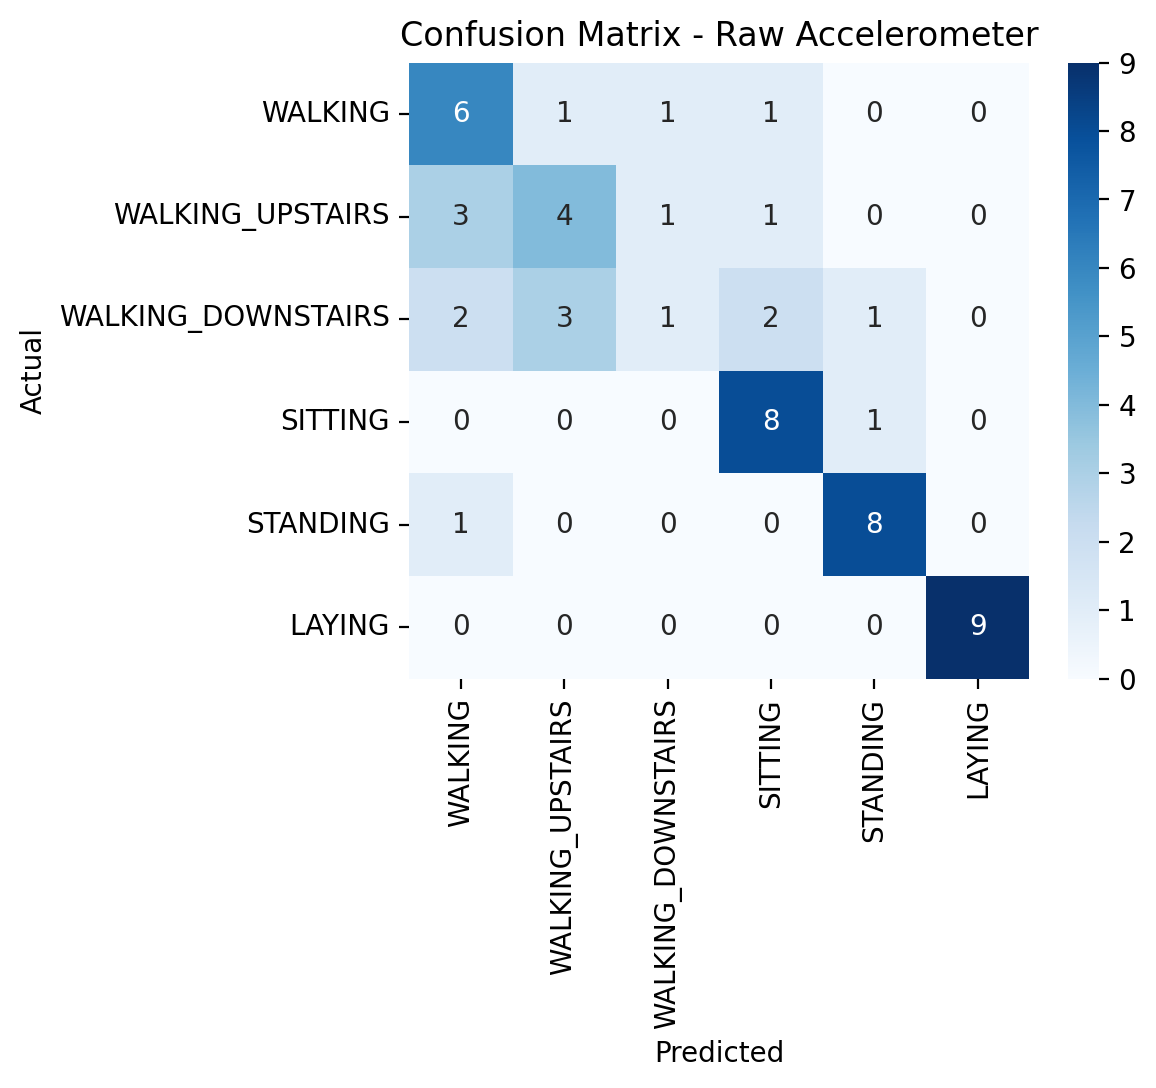

In [ ]:
# ================= Raw Accelerometer =================
X_flat = X.reshape(X.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.3, random_state=42, stratify=y)
dt_raw = DecisionTreeClassifier(max_depth=7, criterion="entropy", random_state=42)
dt_raw.fit(X_train, y_train)
y_pred_raw = dt_raw.predict(X_test)
print("=== Raw Accelerometer Data Model ===")
print("Accuracy :", accuracy_score(y_test, y_pred_raw))
print("Precision:", precision_score(y_test, y_pred_raw, average="weighted"))
print("Recall   :", recall_score(y_test, y_pred_raw, average="weighted"))
cm = confusion_matrix(y_test, y_pred_raw)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix - Raw Accelerometer')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

=== TSFEL Features Model ===
Accuracy : 0.8518518518518519
Precision: 0.8842592592592593
Recall   : 0.8518518518518519


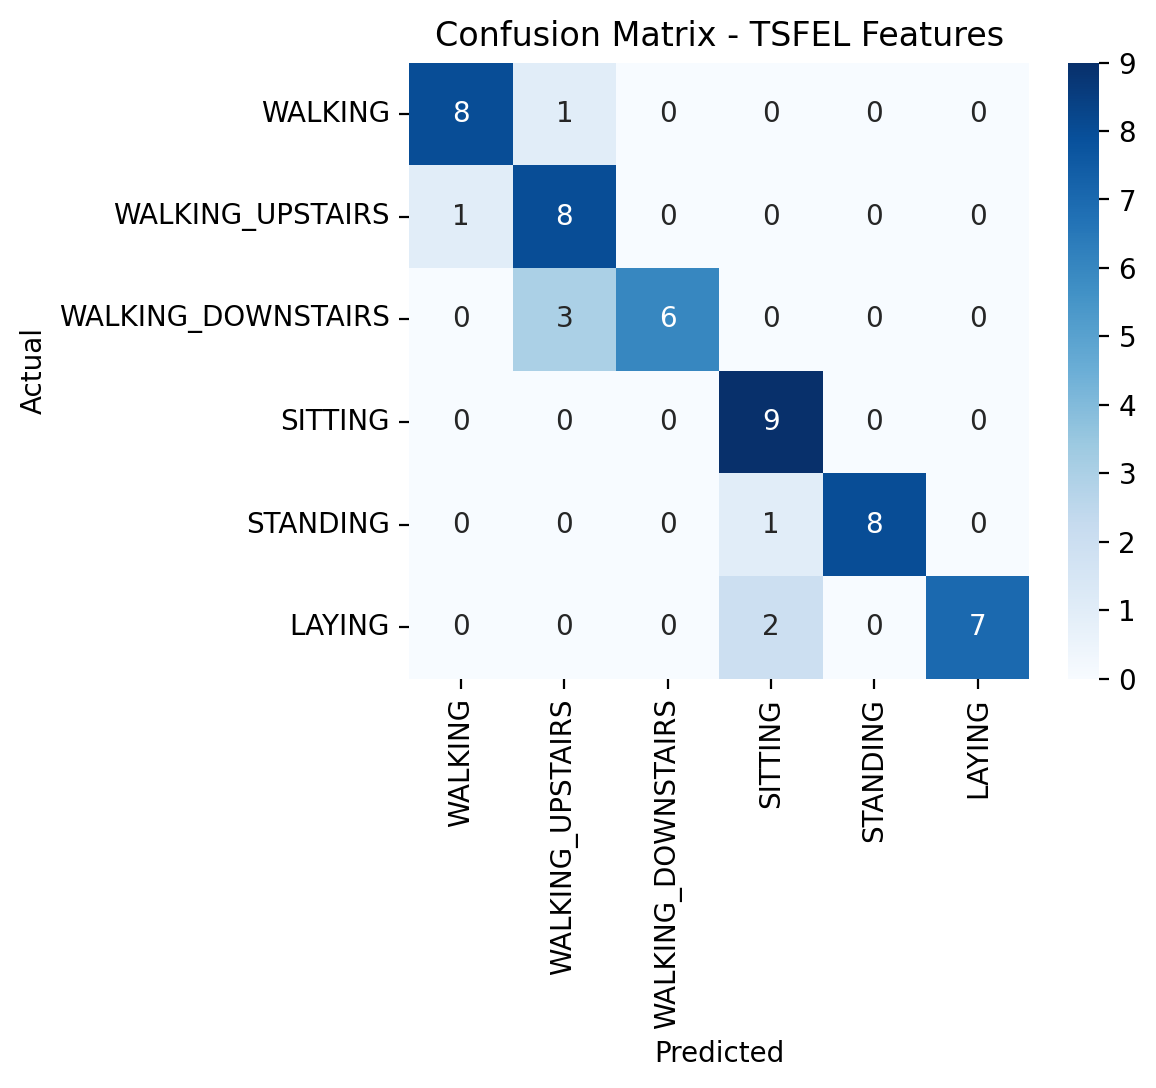

In [ ]:
# ================= TSFEL Features =================
cfg = tsfel.get_features_by_domain()
X_tsfel = []
for i in range(len(X)):
    ts = X[i].flatten()
    feats = tsfel.time_series_features_extractor(cfg, ts, fs=50, verbose=0)
    X_tsfel.append(feats.values.flatten())
X_tsfel = np.array(X_tsfel)
X_train, X_test, y_train, y_test = train_test_split(X_tsfel, y, test_size=0.3, random_state=42, stratify=y)
dt_tsfel = DecisionTreeClassifier(max_depth=7, criterion="entropy", random_state=42)
dt_tsfel.fit(X_train, y_train)
y_pred_tsfel = dt_tsfel.predict(X_test)
print("=== TSFEL Features Model ===")
print("Accuracy :", accuracy_score(y_test, y_pred_tsfel))
print("Precision:", precision_score(y_test, y_pred_tsfel, average="weighted"))
print("Recall   :", recall_score(y_test, y_pred_tsfel, average="weighted"))
cm = confusion_matrix(y_test, y_pred_tsfel)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix - TSFEL Features')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Train a decision tree model using the features provided in the dataset. Report the accuracy, precision, recall and confusion matrix of the model.

/tmp/ipython-input-4281284356.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train_eng = pd.read_csv("UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None)
/tmp/ipython-input-4281284356.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train_eng = pd.read_csv("UCI HAR Dataset/train/y_train.txt", delim_whitespace=True, header=None).values.ravel()
/tmp/ipython-input-4281284356.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test_eng = pd.read_csv("UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None)
/tmp/ipython-input-4281284356.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version.

=== Engineered Features Model ===
Accuracy : 0.8408551068883611
Precision: 0.8403309413719615
Recall   : 0.8408551068883611


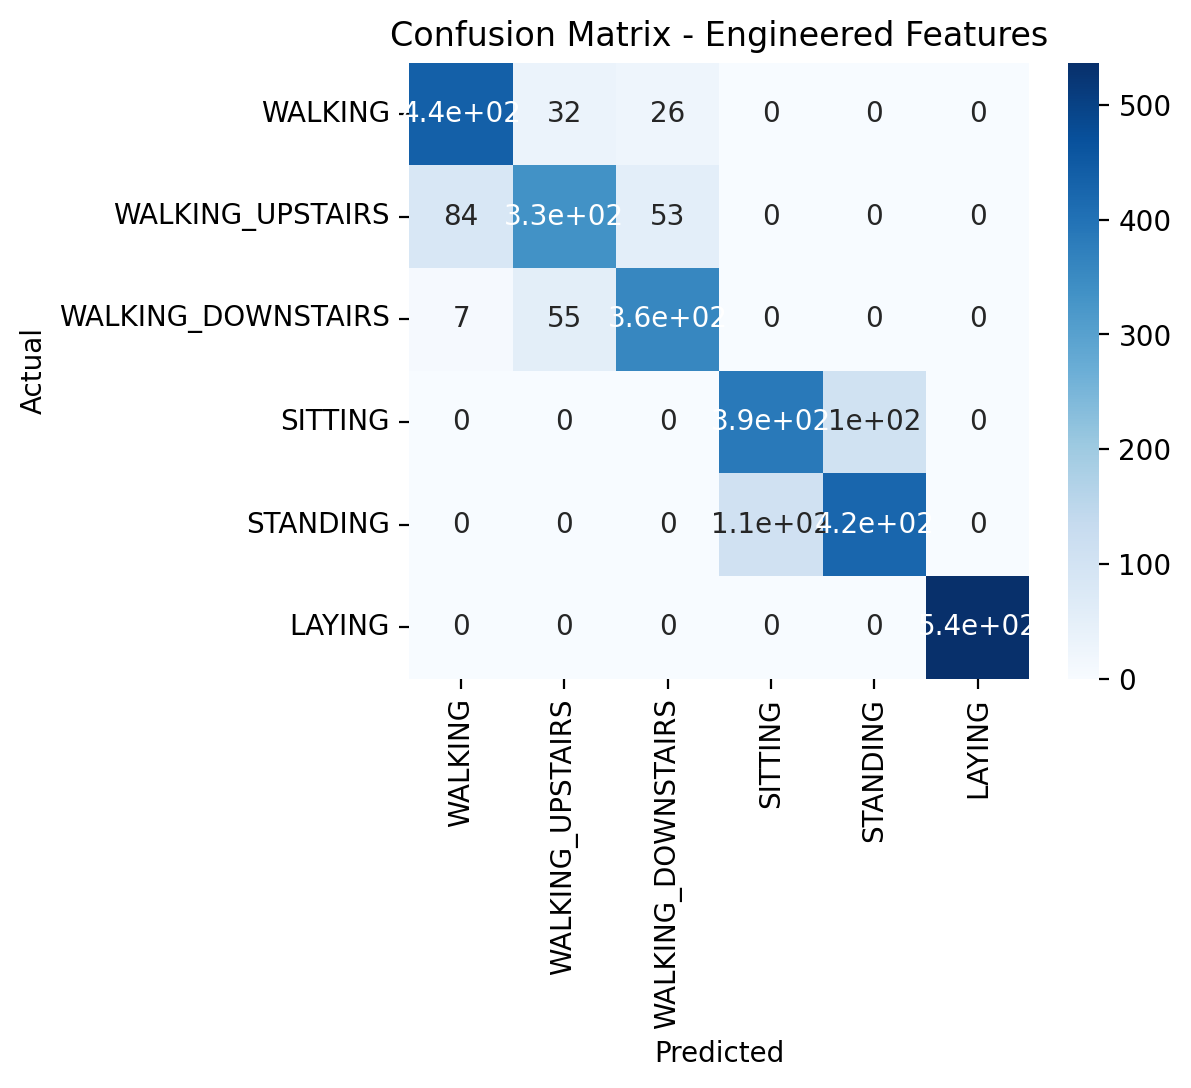

In [ ]:
# ================= Engineered HAR Features =================
X_train_eng = pd.read_csv("UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None)
y_train_eng = pd.read_csv("UCI HAR Dataset/train/y_train.txt", delim_whitespace=True, header=None).values.ravel()
X_test_eng = pd.read_csv("UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None)
y_test_eng = pd.read_csv("UCI HAR Dataset/test/y_test.txt", delim_whitespace=True, header=None).values.ravel()
dt_eng = DecisionTreeClassifier(max_depth=7, criterion="entropy", random_state=42)
dt_eng.fit(X_train_eng, y_train_eng)
y_pred_eng = dt_eng.predict(X_test_eng)
print("=== Engineered Features Model ===")
print("Accuracy :", accuracy_score(y_test_eng, y_pred_eng))
print("Precision:", precision_score(y_test_eng, y_pred_eng, average="weighted"))
print("Recall   :", recall_score(y_test_eng, y_pred_eng, average="weighted"))
cm = confusion_matrix(y_test_eng, y_pred_eng)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix - Engineered Features')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Compare the results of the three models. Which model do you think is better?

Result of Model with features in dataset > Model obtained by TSFEL > Model using raw accelerometer data. Model with features in dataset is the best model as it incorporates 561 features among which few maybe really critical ones.

Q2 Train Decision Tree with varying depths (2-8) using all above 3 methods. Plot the accuracy of the model on test data vs the depth of the tree. [1 marks]

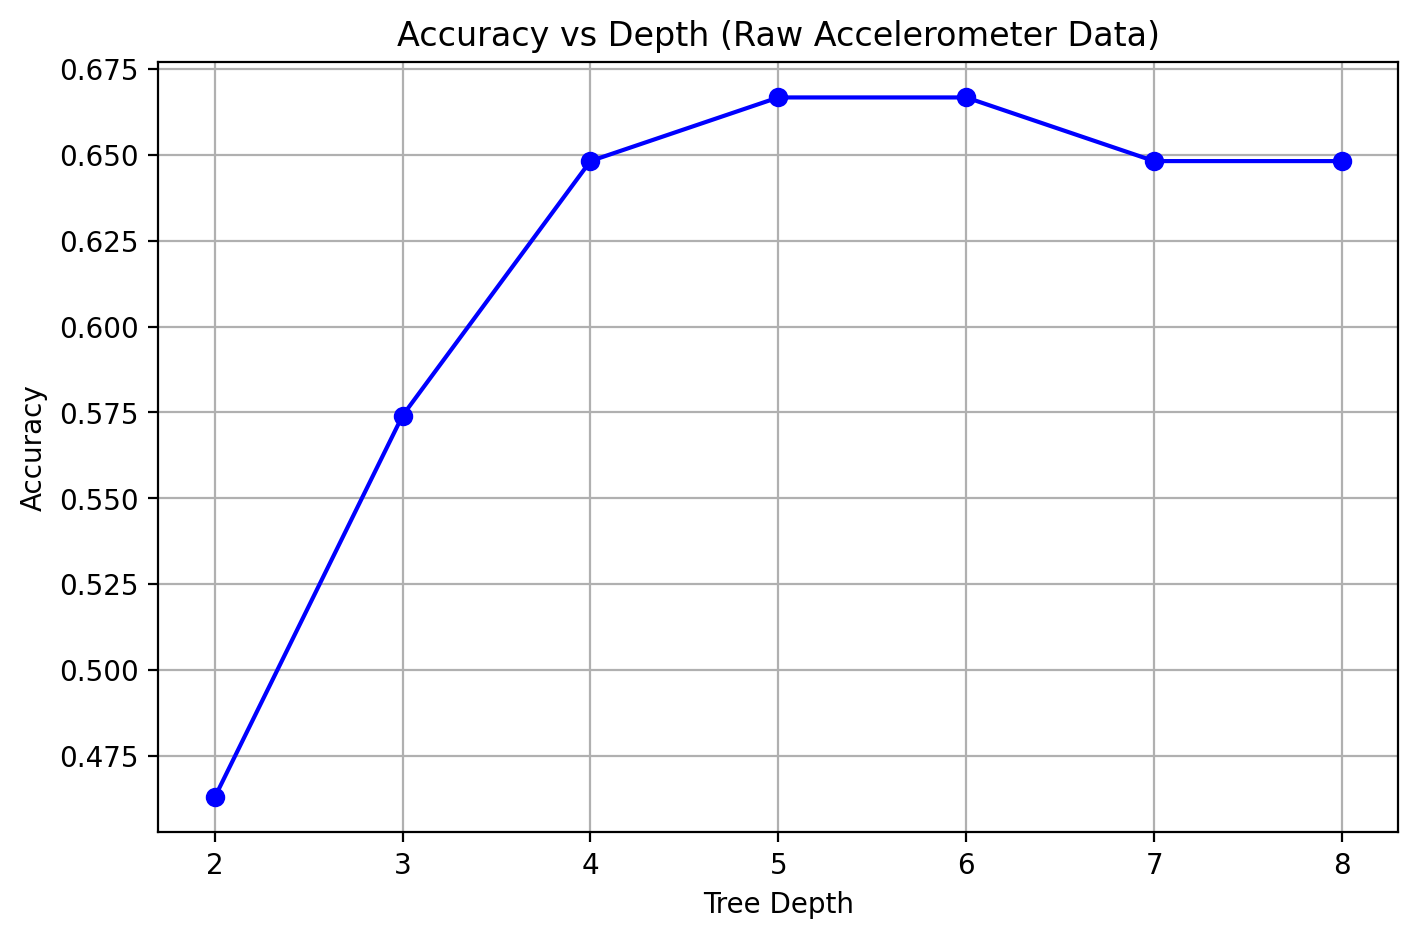

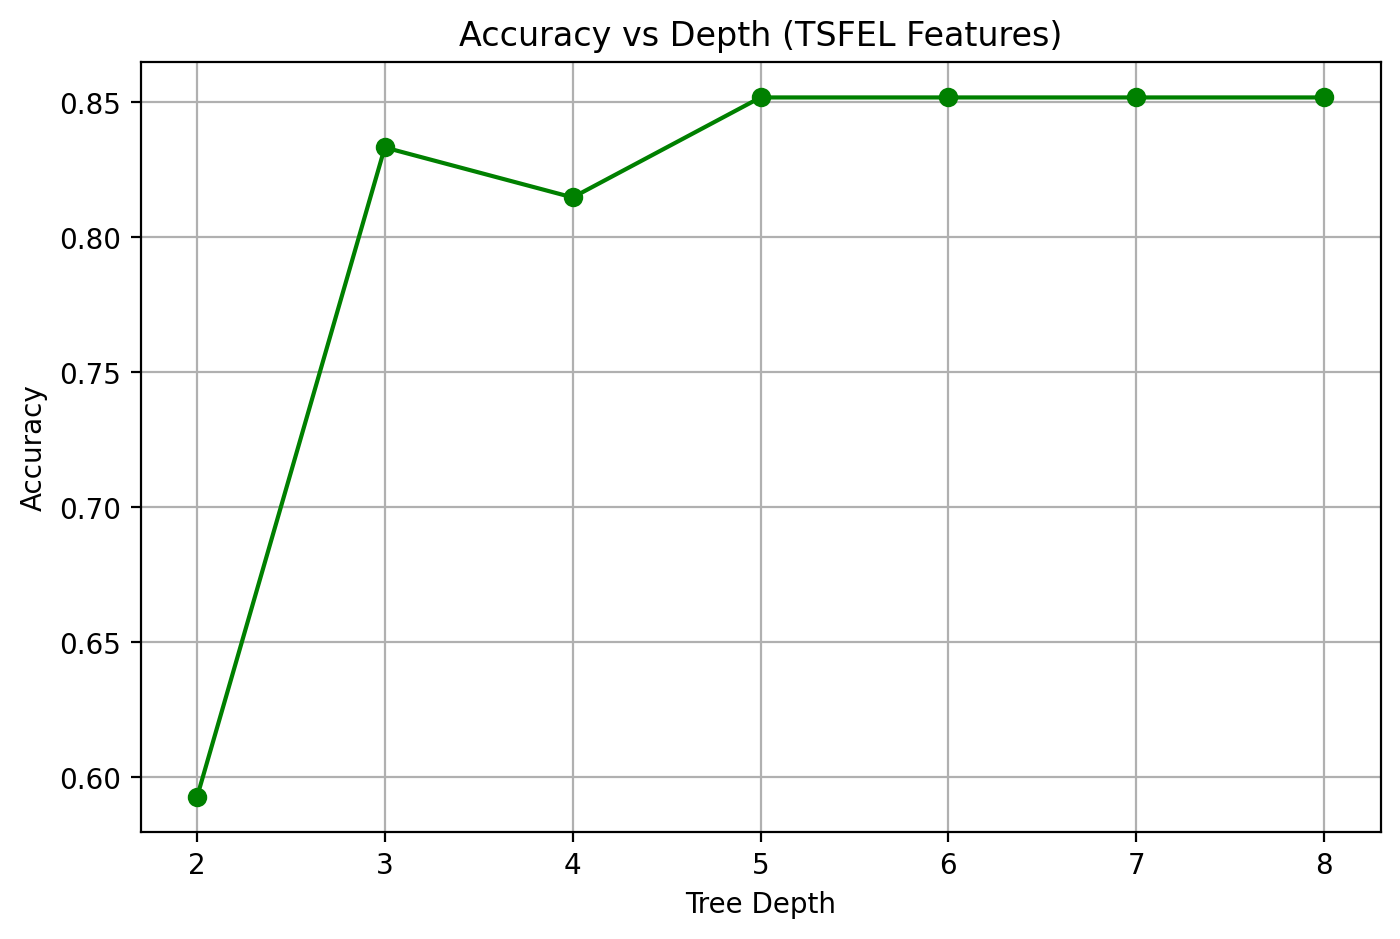

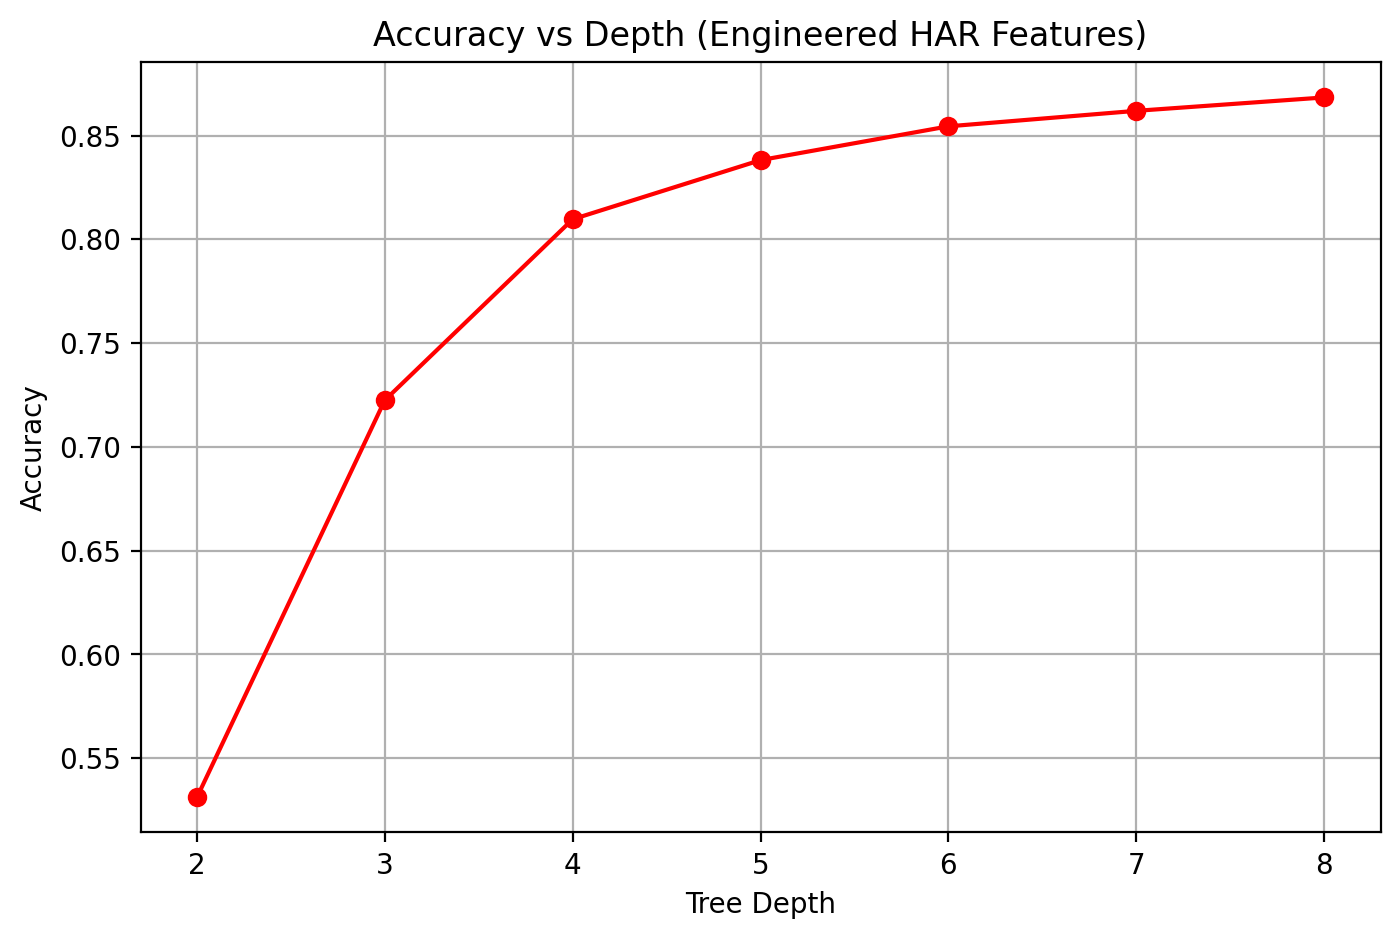

In [ ]:
# ================= Accuracy vs Depth =================
depths = range(2, 9)

acc_raw = []
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.3, random_state=42, stratify=y)
for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    dt.fit(X_train, y_train)
    acc_raw.append(dt.score(X_test, y_test))
plt.figure(figsize=(8,5))
plt.plot(depths, acc_raw, marker='o', color='b')
plt.title("Accuracy vs Depth (Raw Accelerometer Data)")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

acc_tsfel = []
X_train, X_test, y_train, y_test = train_test_split(X_tsfel, y, test_size=0.3, random_state=42, stratify=y)
for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    dt.fit(X_train, y_train)
    acc_tsfel.append(dt.score(X_test, y_test))
plt.figure(figsize=(8,5))
plt.plot(depths, acc_tsfel, marker='o', color='g')
plt.title("Accuracy vs Depth (TSFEL Features)")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

acc_eng = []
for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    dt.fit(X_train_eng, y_train_eng)
    acc_eng.append(dt.score(X_test_eng, y_test_eng))
plt.figure(figsize=(8,5))
plt.plot(depths, acc_eng, marker='o', color='r')
plt.title("Accuracy vs Depth (Engineered HAR Features)")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

Q3 Are there any participants/ activitivies where the Model performace is bad? If Yes, Why? [0.5 mark]

Yes. The model performs worse on activities like WALKING, WALKING_UPSTAIRS, and WALKING_DOWNSTAIRS, because their accelerometer signal patterns are very similar and only differ subtly in amplitude and direction. Additionally, in some cases STANDING vs SITTING are confused, since both generate nearly flat accelerometer signals with minimal variation. These limitations arise because decision trees are axis-aligned and struggle with overlapping feature distributions.